In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf
import os

In [5]:
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

In [93]:
books_path = "./books-autoencoder/"
new_path = "../"
books_list = sorted(os.listdir(books_path))

documents = list()

for i in books_list:
    f = open(books_path + i, 'r')
    doc = list(map(lambda x: x.replace("\n", ""), f.readlines()))
    doc = [x.replace("</s>", "") for x in doc]
    documents.extend(doc)


    f.close()

In [94]:
maxlen = 0
for doc in documents:
    if len(doc) > maxlen:
        maxlen = len(doc)

In [95]:
maxlen

9219

In [96]:
inputs = []
for sentence in documents:
    sentence = sentence.strip()
    inputs.append(sentence)

In [97]:
targets = inputs

In [98]:
n_of_val = int(len(inputs)*0.2)
n_of_val

2101

In [99]:
train_inputs = inputs[:-n_of_val]
train_targets = targets[:-n_of_val]

test_inputs = inputs[-n_of_val:]
test_targets = targets[-n_of_val:]

In [100]:
print(len(train_inputs))
print(len(train_targets))
print(len(test_inputs))
print(len(test_targets))

8405
8405
2101
2101


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 2406
텍스트의 평균 길이 : 76.20321720921378


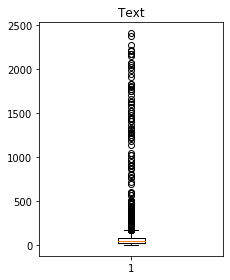

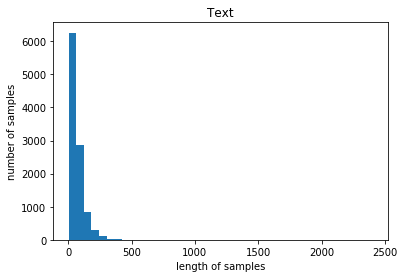

In [101]:
text_len = [len(s.split()) for s in documents]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [102]:
# 서브워드텍스트인코더를 사용하여 질문, 답변 데이터로부터 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    inputs, target_vocab_size=2**13)

In [103]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [104]:
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(inputs[20])))

임의의 질문 샘플을 정수 인코딩 : [20, 2124, 10, 771, 410, 3006, 3, 379, 335, 272, 34, 91, 272, 1055, 51, 8239, 8145, 8184, 2805, 3778, 1603, 695, 111, 1848, 7, 5, 381, 4122, 1018, 1041, 12, 430, 5542, 8036, 91, 790, 64, 54, 1018, 5581, 106, 2206, 88, 919, 11, 915, 2, 8239, 8134, 8145, 277, 72, 40, 7, 97, 2124, 1, 748, 41, 978, 5278, 2203, 38, 2124, 1, 626, 1382, 18, 4870, 1208, 547, 8036, 11, 216, 79, 115, 5703, 3412, 170, 5014, 4, 1728, 1649, 5876, 1391, 9, 1536, 1536, 61, 135, 1803, 304, 4673, 936, 154, 5944, 610, 3006, 34, 84, 1152, 1848, 7, 796, 38, 56, 5876, 258, 512, 77, 3401, 2, 697, 1990, 46, 428, 187, 837, 6081, 8036, 1743, 6501, 7, 671, 8036, 124, 3006, 21, 3778, 6501, 1, 1848, 7, 64, 54, 3729, 2565, 8036, 1848, 32, 373, 1774, 91, 599, 1209]


In [105]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = inputs[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))


정수 인코딩 후의 문장 [20, 2124, 10, 771, 410, 3006, 3, 379, 335, 272, 34, 91, 272, 1055, 51, 8239, 8145, 8184, 2805, 3778, 1603, 695, 111, 1848, 7, 5, 381, 4122, 1018, 1041, 12, 430, 5542, 8036, 91, 790, 64, 54, 1018, 5581, 106, 2206, 88, 919, 11, 915, 2, 8239, 8134, 8145, 277, 72, 40, 7, 97, 2124, 1, 748, 41, 978, 5278, 2203, 38, 2124, 1, 626, 1382, 18, 4870, 1208, 547, 8036, 11, 216, 79, 115, 5703, 3412, 170, 5014, 4, 1728, 1649, 5876, 1391, 9, 1536, 1536, 61, 135, 1803, 304, 4673, 936, 154, 5944, 610, 3006, 34, 84, 1152, 1848, 7, 796, 38, 56, 5876, 258, 512, 77, 3401, 2, 697, 1990, 46, 428, 187, 837, 6081, 8036, 1743, 6501, 7, 671, 8036, 124, 3006, 21, 3778, 6501, 1, 1848, 7, 64, 54, 3729, 2565, 8036, 1848, 32, 373, 1774, 91, 599, 1209]
기존 문장: 하고 누나를 두고 물었다 공장이 청계천에서 부천인가 어덴가로 옮겼다 카면서 편지가 한 장 왔어예 돈도 삼만원 부쳐오고예 그거 하매 보름은 됐을 낍니더 내 가 말했다 누나는 올해 열 아홉 살이었다 누나는 먼저 서울로 올라가 자리를 잡 은 방구리댁 딸 두남이의 편지를 받고 작년 봄에 홀홀히 상경 하여 처음에는 완구 만드는 작은 공장에서 일한다는 편지가 왔었다 그리고 작년 추석때 시골을 한번 다녀가곤 몇 달 소식이 끊겼다가 봉 제공장으로 옮겼다는 편지

In [106]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

20 ----> 하고 
2124 ----> 누나
10 ----> 를 
771 ----> 두고 
410 ----> 물었다 
3006 ----> 공장
3 ----> 이 
379 ----> 청
335 ----> 계
272 ----> 천
34 ----> 에서 
91 ----> 부
272 ----> 천
1055 ----> 인가 
51 ----> 어
8239 ----> �
8145 ----> �
8184 ----> �
2805 ----> 가로 
3778 ----> 옮
1603 ----> 겼다 
695 ----> 카
111 ----> 면서 
1848 ----> 편지
7 ----> 가 
5 ----> 한 
381 ----> 장 
4122 ----> 왔어
1018 ----> 예 
1041 ----> 돈
12 ----> 도 
430 ----> 삼
5542 ----> 만원
8036 ---->  
91 ----> 부
790 ----> 쳐
64 ----> 오
54 ----> 고
1018 ----> 예 
5581 ----> 그거 
106 ----> 하
2206 ----> 매 
88 ----> 보
919 ----> 름
11 ----> 은 
915 ----> 됐
2 ----> 을 
8239 ----> �
8134 ----> �
8145 ----> �
277 ----> 니
72 ----> 더 
40 ----> 내 
7 ----> 가 
97 ----> 말했다 
2124 ----> 누나
1 ----> 는 
748 ----> 올
41 ----> 해 
978 ----> 열 
5278 ----> 아홉 
2203 ----> 살이
38 ----> 었다 
2124 ----> 누나
1 ----> 는 
626 ----> 먼저 
1382 ----> 서울
18 ----> 로 
4870 ----> 올라가 
1208 ----> 자리를 
547 ----> 잡
8036 ---->  
11 ----> 은 
216 ----> 방
79 ----> 구
115 ----> 리
5703 ----> 댁 
3412 ----> 딸 
1

In [107]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 512

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    # 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [108]:
train_inputs, train_targets = tokenize_and_filter(train_inputs, train_targets)
test_inputs, test_targets = tokenize_and_filter(test_inputs, test_targets)

In [109]:
print('질문 데이터의 크기(shape) :', train_inputs.shape)
print('답변 데이터의 크기(shape) :', train_targets.shape)

print('질문 데이터의 크기(shape) :', test_inputs.shape)
print('답변 데이터의 크기(shape) :', test_targets.shape)

질문 데이터의 크기(shape) : (8405, 512)
답변 데이터의 크기(shape) : (8405, 512)
질문 데이터의 크기(shape) : (2101, 512)
답변 데이터의 크기(shape) : (2101, 512)


In [110]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_inputs,
        'dec_inputs': train_targets[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': train_targets[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))


dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# model

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [112]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        cfg = super().get_config()
        return cfg
    
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


In [113]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights


In [114]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값.
        # 논문 기준 : 64
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        cfg = super().get_config()
        return cfg
    
    # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs


In [115]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [116]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [117]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크(두번째 서브층)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [118]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [119]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [120]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [121]:
tf.keras.backend.clear_session()

# Hyper-parameters
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

#model = tf.keras.utils.multi_gpu_model(model, gpus=2)

(1, 8262, 256)
(1, 8262, 256)


In [122]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    3169280     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [123]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        cfg = super().get_config()
        return cfg
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

sample_learning_rate = CustomSchedule(d_model=128)

In [124]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)


In [125]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
from tensorflow.python.keras.callbacks import TensorBoard
from time import time

EPOCHS = 50


#tensorboard = TensorBoard(log_dir='./graph', histogram_freq=0, write_graph=True, write_images=True)
history = model.fit(dataset, epochs=EPOCHS)


Epoch 1/50
132/132 [==============================] - 66s 503ms/step - loss: 2.0966 - accuracy: 0.0051
Epoch 2/50
132/132 [==============================] - 61s 464ms/step - loss: 1.9603 - accuracy: 0.0078
Epoch 3/50
132/132 [==============================] - 61s 464ms/step - loss: 1.8772 - accuracy: 0.0078
Epoch 4/50
132/132 [==============================] - 61s 465ms/step - loss: 1.8527 - accuracy: 0.0098
Epoch 5/50
132/132 [==============================] - 61s 466ms/step - loss: 1.7804 - accuracy: 0.0136
Epoch 6/50
132/132 [==============================] - 61s 466ms/step - loss: 1.6956 - accuracy: 0.0183
Epoch 7/50
132/132 [==============================] - 62s 466ms/step - loss: 1.6051 - accuracy: 0.0252
Epoch 8/50
132/132 [==============================] - 62s 467ms/step - loss: 1.4701 - accuracy: 0.0401
Epoch 9/50
132/132 [==============================] - 62s 468ms/step - loss: 1.1325 - accuracy: 0.0808
Epoch 10/50
132/132 [==============================] - 62s 467ms/step - l

In [72]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': test_inputs,
        'dec_inputs': test_targets[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': test_targets[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))


dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [73]:
loss_and_metrics = model.evaluate(dataset)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

33/33 [==============================] - 4s 112ms/step - loss: 0.0370 - accuracy: 0.3517
## evaluation loss and_metrics ##
[0.037026542887994736, 0.3517018]


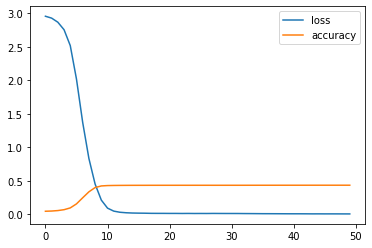

In [74]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()




In [75]:
def evaluate(sentence):
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    output = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 예측 시작
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # 현재(마지막) 시점의 예측 단어를 받아온다.
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 마지막 시점의 예측 단어를 출력에 연결한다.
        # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

def predict(sentence):
    prediction = evaluate(sentence)

    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])
    

    
    if sentence != predicted_sentence:
        print('Input: {}'.format(sentence))
        print('Output: {}'.format(predicted_sentence))
    return predicted_sentence



In [76]:
for sent in inputs[-n_of_val:]:
    predict(sent)
    print("=" * 50)

Input: 바로 팔월십사일까지도 그러하였다 팔월십사일까지도 흥 한덕문이 길천이한테 논 팔아먹던 대 났구나 는 당당히 행세를 하였었다 그랬던 것이 팔월십오일에 일본이 항복을 하고 조선은 독립실상은 우선 해방이 되고 하였다 그리고 며칠 아니하여 일인들이 토지와 그 밖에 온갖 재산을 죄다 그대로 내어 놓고 보따리 하나에 몸만 쫓 기어 가게 되었다는 데까지 이르렀다
Output: 바로 팔월십사일까지도 그러하였다 팔월십사일까지도 흥 한덕문이 길천이한테 논 팔아먹던 대 났구나 는 당당히 행세를 하였었다 그랬던 것이 팔월십오일에 일본이 항복을 하고 조선은 독립독립은 우선 해방이 되고 하였다 그리고 며칠 아니하여 일인들이 토지와 그 밖에 온갖 재산을 죄다 그대로 내어 놓고 보따리 하나에 몸만 쫓 기어 가게 되었다는 데까지 이르렀다
Input: 저 읍내 사는 영남이가 산판 하날 나서 벌목을 하는데 이 동네 사람들더러 와 남구 비어 주구 그대신 우죽 가져 가라 구 하니 용길이두 며칠 보내서 땔나무나 좀 장만하시죠 걸 누가 논을 도루 찾았는데 논만 찾으면 땔나문 없어두 사시나요 논두 없이두 설흔다섯해나 살지 않었느냐 허허 참 그러지 마시구 며칠 보내세요 어서서 다 비어버려야 할 텐데 도무지 사람을 뭇 구해 그러니 절더러 부디 그렇거두룩 서둘러 달라구 영남이가 여간만 부탁을 해싸여죠
Output: 저 읍내 사는 영남이가 산판 하날 나서 벌목을 하는데 이 동네 사람들더러 와 남구 비어 주구 그대신 우죽 가져 가라 구 하니 용길이두 며칠 보내서 땔나무나 좀 장만하시죠 걸 누가 논을 도루 찾았는데 논만 찾으면 땔나문 없어두 사시나요 논두 없이두 설흔다섯해나 살지 않었느냐 허허 참 그러지 마시구 며칠 보내세요 어서서 다 비어버려야 할 텐데 도무지 사람을 뭇 구해 그러니 절더러 부디 그렇거두룩 서둘러 달라구 영남이가 여간만 부탁을 해싸여
Input: 뭐 어디 빈자리가 있어야지 K사장은 안락의자에 폭신 파묻힌 몸을 뒤로 벌떡 젖히며 하품을 하 듯이 시원찮게 대답을 한 다 두팔을 쭉 내뻗고 

Input: 술값을 치르는 것을 보고 P도 따라 일어섰다 M이 몸뚱이로 슬쩍 밀 어서 방안으로 들여보내 고 뒤에서 계집애가 양복 뒷깃을 잡아당긴다 그래라 자고 간다 P는 방 가운데 벌떡 드러누웠다 너희 집이 어디냐 계집애가 옆에 와서 앉는 것을 보고 P가 물었다 도  언제 왔니 작년에 P는 몸을 일으켰다 또 속이 왈칵 뒤집혀 좀더 진정하려고 하는 생 각인데 계집애가 콱 밀어 뜨린 다
Output: 술값을 치르는 것을 보고 P도 따라 일어섰다 M이 몸뚱이로 슬쩍 밀 어서 방안으로 들여보내 고 뒤에서 계집애가 양복 뒷깃을 잡아당긴다 그래라 자고 간다 P는 방 가운데 벌떡 드러누웠다 너희 집이 어디냐 계집애가 옆에 와서 앉는 것을 보고 P가 물었다 도  언제 왔니 작년에 P는 P는 몸을  또 속이 왈칵 뒤집혀 좀더 진정하려고 하는 생 각인데 계집애가 콱 밀어 뜨린 다
Input: 이것이 처세상 퍽 이롭지 못한 것을 P도 잘 안다 또 공연한 승벽이 요 고집인 줄 알건만 그 는 그 것을 고치지 못한다 이날 밤에도 그는 그 계집애를 조금도 어떻게 하겠다는 생각은 나지 아니하였다 술취한 끝에 속이 괴로우니까 진정을 하자는 판인데 오십전 아니 이십 전도 좋아하는 소리 에 버 쩍 흥분이 된 것이다 너무도 인간이 단작스럽고 악착스러운 것 같았다 P가 노상 보고 듣 는 세상이 돈을 중간에 놓고 악착스럽게 으르렁으르렁하는 것임을 모르는 바는 아니나 정조 댓가로 일금 이십 전을 요구하는 것 은 처음 보았다 P는 그러한 여자가 정조를 파는 데 무신경한 것도 잘 알고 있으며 따라서 그것이 비도덕 이니 어쩌니 하는 것도 아니다 그의 관점과 해석은 그런 것보다 더 나아간 입장에 있었다 그러나 이십 전만 주어도 소리에는 이것저것 생각하고 헤아릴 나위도 없었다
Output: 이것이 처세상 퍽 이롭지 못한 것을 P도 잘 안다 또 공연한 승벽이 요 고집인 줄 알건만 그 는 그 것을 고치지 못한다 이날 밤에도 그는 그 계집애를 조금도 어떻게 하겠다는 생각은 나지 아니하였다 술취한 끝에 속이 괴로우니

Input: 일찍 맛보지 못한 새살림을 P는 시작하였다 창선이가 도착한 날 밤 창선이는 아랫목에서 색색 잠을 자고 있다 외롭게 꿈을 꾸고 있으려 니 생각하매 전에 없던 애정 이 솟아오르는 듯하였다 이튿날 아침 일찍 창선이를 데리고 인쇄소에 가서 A에게 맡기고 안 내키는 발길을 돌이 켜 나오는 P는 혼자 중얼거렸다 레디메이드 인생이 비로소 겨우 임자를 만나 팔리었구나
Output: 일찍 맛보지 못한 새살림을 P는 시작하였다 창선이가 도착한 날 밤 창선이는 아랫목에서 색색 잠을 자고 있다 외롭게 꿈을 꾸고 있으려 니 생각하매 전에 없던 애정 이 솟아오르는 듯하였다 이튿날 아침 일찍 창선이를 데리고 에에 가서 A에게 맡기고 안 내키는 발길을 돌이 켜 나오는 P는 혼자 중얼거렸다 레디메이드 인생이 비로소 겨우 임자를 만나 팔리었구나
Input: 이렇게 몹시 춥고 두려운 날 아침에 문서방은 집을 나섰다 산산이 흐 트러진 머리카락을 뿌연 상투에 휘휘 거둬 감고 수건으로 이마를 질 끈 동인 위에 까맣게 그을은 대팻밥 모자를 끈 달아 썼다 부대처럼 툭툭한 토수래베실을 삶아서 짠 것이다 바지저고리는 언제 입은 것 인지 뚫어지고 흙투성이 되었는데 바람에 무겁게 흩날린다 문서뱅이 발써 갔소 문서방은 짚신에 들막을 단단히 하고 마당에 내려서려다가 부르는 소 리에 머리를 돌렸다 펄쩍 문을 열면서 때가 찌덕찌덕한 늙은 얼굴을 내미는 것은 한관청  관청은 직함이었다 왜 그러시우 경기 말씨가 그저 남아 있는 문서방은 한 발로 마당을 밟고 한 발로 흙마루를 밟은 채 한관청을 보았다
Output: 이렇게 몹시 춥고 두려운 날 아침에 느은 집을 나섰다 산산이 흐 트러진 머리카락을 뿌연 상투에 휘휘 거둬 감고 수건으로 이마를 질 끈 동인 위에 까맣게 그을은 대팻밥 모자를 끈 달아 썼다 부대처럼 툭툭한 토수래베실을 삶아서 짠 것이다 바지저고리는 언제 입은 것 인지 뚫어지고 흙투성이 되었는데 바람에 무겁게 흩날린다 문서뱅이 발써 갔소 아리은 짚신에 들막을 단단히 하고 마당에 내려서려다가 부르는 소 

Input: 빈 마음만 흐르는 구름에 부쳐서 내지로 보낼 뿐이었다 어째서 대답이 어부소 응 그래 울리 비디디 안 가파 창우니 빠피 야이놈 껍질 벗긴다 인가는 담뱃대를 꽁무니에 찌르면서 일어나 앉더니 팔을 걷는다 그것 을 본 문서방 아내는 낯빛이 파랗게 질려서 부들부들 떨면서 이편만 본다 문서방도 낯빛이 까맣게 죽었다 자 그러면 금년 농사는 온통 드리지요
Output: 빈 마음만 흐르는 구름에 부쳐서 내지로 보낼 뿐이었다 어째서 대답이 어부소 응 그래 울리 비디디 안 가파 창우니 빠피 야이놈 껍질 벗긴다 인가는 담뱃대를 꽁무니에 찌르면서 일어나 앉더니 팔을 걷는다 그것 을 본 넌  아내는 낯빛이 파랗게 질려서 부들부들 떨면서 이편만 본다 의자 도 낯빛이 까맣게 죽었다 자 그러면 금년 농사는 온통 드리지요
Input: 문서방의 목소리는 힘없이 떨렸다 마치 종아리채를 든 초학 훈장 앞 에 엎드린 어린애의 소리처럼 부요우일없다 퉁퉁디 모모 모두 우리 가져가두 보미옥수수 쓰단4 쌔옌소금 얼씨진20 쏘미좁쌀디 빠단8디 유아있 다 니디 자리 알라 있소 그거 안 줘 검붉은 인가의 뺨은 성난 두꺼비 배처럼 불떡불떡하였다 나머지는 내년에 갚지요 문서방은 머리를 뚝 떨어뜨렸다 슴마무엇 창우니 빠피야
Output: 누 의 목소리는 힘없이 떨렸다 마치 종아리채를 든 초학 훈장 앞 에 엎드린 어린애의 소리처럼 부요우일없다 퉁퉁디 모모 모두 우리 가져가두 보미옥수수 쓰단4 쌔옌소금 얼씨진20 쏘미좁쌀디 빠단8디 유아있 다 니디 자리 알라 있소 그거 안 줘 검붉은 인가의 뺨은 성난 두꺼비 배처럼 불떡불떡하였다 나머지는 내년에 갚지요 모양을 은 머리를 뚝 떨어뜨렸다 슴마무엇 창우니 빠피야
Input: 인가의 억센 손이 문서방의 멱살을 잡았다 문서방은 가만히 받았다 정신이 아찔하였다 에구 장구재 흑흑 장구재 제발 살려 줍쇼 제발 살려 주시 면 뼈를 팔아서라두 갚겠습니다 장구재 제발 문서방의 아내는 부들부들 떨면서 인가의 팔에 매달렸다 그의 애걸하 는 소리는 벌써 울음에 떨렸다 내 보미 워디 

Input: 문서방은 인가를 따라서 밖으로 나오면서 울었다 등뒤에서는 웃음 소 리가 들렸다 그러나 그 웃음 소리는 이때의 문서방에게는 아무러한 자극도 주지 못하였다 자 이게 적지만 마당에 한참이나 서서 무엇을 생각하던 인가는 백 조짜리 관체   돈석 장을 문서방의 손에 쥐였다
Output: 노력은 인가를 따라서 밖으로 나오면서 울었다 등뒤에서는 웃음 소 리가 들렸다 그러나 그 웃음 소리는 이때의 모양을 아무아무러한 자극도 주지 못하였다 자 이게 적지만 마당에 한참이나 서서 무엇을 생각하던 인가는 백 조짜리 관체   돈석 장을 편안의 손에 쥐였다
Input: 문서방은 받지 않으려고 했다 더러운 놈의 더러운 돈을 받지 않으려 하였다
Output: 츠은 받지 않으려고 했다 더러운 놈의 더러운 돈을 받지 않으려 하였다
Input: 그러나 지금 부 쳐 먹는 밭도 인가의 밭이다 잠깐 사이 분과 설움에 어리어서 튀기던 돈은돈 힘은 굶고 헐벗은 문서방을 누르지 않을 수 없었다 그는 못 이기는 것처럼 삼백 조를 받아 넣고 힘없이 나오다가 저 속에는 용례가 있으려니 생각하면서 바른편에 놓인 조그마한 집을 바라볼 때 자기도 모르게 발길이 도로 돌아섰다 마치 거기서는 용례가 울면서 자기를 부르는 것 같았다 그러나 인가는 문서방을 문 밖에 내보내고 문을 닫아 잠갔 다 문 밖에 나서니 천지가 아득하였다 발길이 돌아가지 않았다 사생을 다투는 아내를 생각하면 아니 가진 못할 일이고 이 울타리 속에는 용 례가 있거니 생각하면 눈길이 다시금 울타리로 갔다
Output: 그러나 지금 부 쳐 먹는 밭도 인가의 밭이다 잠깐 사이 분과 설움에 어리어서 튀기던 돈은돈 힘은 굶고 헐벗은 하며 을 누르지 않을 수 없었다 그는 못 이기는 것처럼 삼백 조를 받아 넣고 힘없이 나오다가 저 속에는 뿌가 있으려니 생각하면서 바른편에 놓인 조그마한 집을 바라볼 때 자기도 모르게 발길이 도로 돌아섰다 마치 거기서는 새가 가 울면서 자기를 부르는 것 같았다 그러나 인가는 틈을 문 밖에 내보내고 문을 닫아 잠갔 다 문 

Input: 뒷산 숲에서 이것을 본 문서방은 그 두 그림자를 향하고 내리뛰었다 그는 천방지방 내리뛰었다 독살이 잔뜩 올라서 불빛에 번쩍이는 그의 눈에는 이 두 그림자밖에는 아무것도 보이지 않았다 으윽 끅 문서방이 여러 사람을 헤치고 두 그림자 앞에 가 섰을 때 앞에 섰던 장정의 그림자는 땅에 거꾸러졌다 그때는 벌써 문서방의 손에 쥐었던 도끼가 장정 인가의 머리에 박혔다 도끼를 놓은 문서방의 품에는 어 린 여자의 그림자가 안겼다 용례가
Output: 뒷산 숲에서 이것을 본 진영은 은 그 두 그림자를 향하고 내리뛰었다 그는 천방지방 내리뛰었다 독살이 잔뜩 올라서 불빛에 번쩍이는 그의 눈에는 이 두 그림자밖에는 아무것도 보이지 않았다 으윽 끅 욱이이 여러 사람을 헤치고 두 그림자 앞에 가 섰을 때 앞에 섰던 장정의 그림자는 땅에 거꾸러졌다 그때는 벌써 매기의 손에 쥐었던 도끼가 장정 인가의 머리에 박혔다 도끼를 놓은 츠의 품에는 어 린 여자의 그림자가 안겼다 네 가
Input: 그 바람에 모여 섰던 사람들은 혹은 허둥지둥 뛰어 버리고 혹은 뒤로 자빠져서 부르르 떨었다 용례도 거꾸러지는 것을 안았다 용례야
Output: 그 바람에 모여 섰던 사람들은 혹은 허둥지둥 뛰어 버리고 혹은 뒤로 자빠져서 부르르 떨었다 같기도 도 거꾸러지는 것을 안았다 무야
Input: 놀라지 마라 나다 아버지다 용례야 문서방은 딸을 품에 안으니 이때까지 악만 찼던 가슴이 스르르 풀리 면서 독살이 올랐던 눈에서 뜨거운 눈물이 떨어졌다 이렇게 슬픈 중 에도 그의 마음은 기쁘고 시원하였다 하늘과 땅을 주어도 그 기쁨을 바꿀 것 같지 않았다 그 기쁨 그 기쁨은 딸을 안은 기쁨만이 아니었다
Output: 놀라지 마라 나다 아버지다 편 야 날카로운 은 딸을 품에 안으니 이때까지 악만 찼던 가슴이 스르르 풀리 면서 독살이 올랐던 눈에서 뜨거운 눈물이 떨어졌다 이렇게 슬픈 중 에도 그의 마음은 기쁘고 시원하였다 하늘과 땅을 주어도 그 기쁨을 바꿀 것 같지 않았다 그 기쁨 그 기쁨은 딸을 안은 기쁨만이 아니

Input: 왜냐 선생은 내가 들어 있는 문예반 담당이시니까 선생님은 언젠가 내 글을 보고 말씀하셨다 글은 손으로 쓴다 기보다 마음으로 결국은 온몸으로 쓰는 거다  속뜻은 잘 모르겠지만 그 말 씀이 잊히지 않는 걸 보면 또 글을 잘 쓰고프면 무어든지 자꾸 말로 그려내라고 글감이란 게 어디 고상한 데에 따로 있는 게 아니라고 하 신 말씀이 머리에 새겨져 있는 걸 보 면 내 얼굴에도 국어 선생님을 좋아한다고 쓰여 있을 거다 선생님은 허생전의 줄거리를 잡아오라는 숙제를 내셨다 그냥 말로 하 는 게 좋은데 좌우간 누구를 시킬지 모르니까 말하기가 자신 없는 사 람은 써다 읽어도 좋다고 하셨다 윤수는 가방을 뒤적거리더니 쓴 것 을 내밀었다 빠뜨린 얘기도 있고 말이 어색한 데도 있었다
Output: 왜냐 선생은 내가 들어 있는 문예반 담당이시니까 선생님은 언젠가 내 글을 보고 말씀하셨다 글은 손으로 쓴다 기보다 마음으로 결국은 온몸으로 쓰는 거다  속뜻은 잘 모르겠지만 그 말 씀이 잊히지 않는 걸 보면 또 글을 잘 쓰고프면 무어든지 자꾸 말로 그려내라고 글감이란 게 어디 고상한 데에 따로 있는 게 아니라고 하 신 말씀이 머리에 새겨져 있는 걸 보 면 내 얼굴에도 국어 선생님을 좋아한다고 쓰여 있을 거다 선생님은 허생전의 줄거리를 잡아오라는 숙제를 내셨다 그냥 말로 하 는 게 좋은데 좌우간 누구를 시킬지 모르니까 말하기가 자신 없는 사 람은 써다 읽어도 좋다고 하셨다 정이는 가방을 뒤적거리더니 쓴 것 을 내밀었다 빠뜨린 얘기도 있고 말이 어색한 데도 있었다
Input: 그런데 마지막 문장이 나를 놀라게 하였다 그걸 적어두어야한다 아무도 자기를 알아주지 않아서 허생은 아무도 모르는 곳으로 가 버 렸다  그러니까 허생은 아내 변부자 이완대장 그리고 양민 이 된 도둑들까지 모두가 자기를 알아주지 않았기 때문에 세상이 싫 어서 숨어 버렸다는 거다 그 말이 찌릿하게 가슴에 와 닿았다 아주 엉뚱하면서도 그럴 듯한 면이 있어 윤수를 다시 봐야겠다는 느낌과 함께 왠지 내가 정말 솔직하게 

Input: 그런데 어느 사이엔가 교실 전체가 논쟁마 당이 되어 있었다 논쟁의 한쪽 대장은 동철이였다 나중에 동철이는 회장이라도 되는 양 아주 일어서서 이렇 게 말했다
Output: 그런데 어느 사이엔가 교실 전체가 논쟁마 당이 되어 있었다 논쟁의 한쪽 대장은 철이였다 였다 나중에 동철이는 회장이라도 되는 양 아주 일어서서 이렇 게 말했다
Input: K 내 마음은 분명 선생님 편이지만 선생님께서 판단을 잘 하셨는지 잘 못하셨는지 잘했다면 왜 그런지 알 수 없어서 논쟁 에 끼여들 수 없었다 그런 문제에 대해 내가 너무 아는 게 없음을 절감하였다 다 른 애들처럼 어디서 주워들은 이야기를 자 기 것처럼 뇌까리기는 죽 어도 싫고 솔직히 말해서 그런 일이 내 주변에서 일어나는 것부터가 마땅찮았다 선생님께서 이렇게 될 줄 모르고 조합에 가입하셨다 고는 생각할 수 없다 선생님은 왜냐 선생니까 그러면 알면서도 왜 그러셨 을까 선생님도 나처 럼 때때로 모든 사람이 한심스럽게 보여 남들을 너무 무시하신 걸까 논쟁이 한참 벌어지고 있는데 윤수가 내게로 왔다
Output: K 내 마음은 분명 선생님 편이지만 선생님께서 판단을 잘 하셨는지 잘 못하셨는지 잘했다면 왜 그런지 알 수 없어서 논쟁 에 끼여들 수 없었다 그런 문제에 대해 내가 너무 아는 게 없음을 절감하였다 다 른 애들처럼 어디서 주워들은 이야기를 자 기 것처럼 뇌까리기는 죽 어도 싫고 솔직히 말해서 그런 일이 내 주변에서 일어나는 것부터가 마땅찮았다 선생님께서 이렇게 될 줄 모르고 조합에 가입하셨다 고는 생각할 수 없다 선생님은 왜냐 선생니까 그러면 알면서도 왜 그러셨 을까 선생님도 나처 럼 때때로 모든 사람이 한심스럽게 보여 남들을 너무 무시하신 걸까 논쟁이 한참 벌어지고 있는데 그레가 내게로 왔다
Input: 휴식 시간이 아닌데 그 래서는 안 된다는 생각이 얼핏 들었지만 될 대로되라는 심정이었다 윤수는 흥분해서 심하게 더듬거렸다 걔의 말을 주워 모으면 이렇다 왜냐 선생 결국 쫓겨날 거다 허생처 럼 어디론가 사라져 버

Input: 일 주일에 한두 번 대여섯 시간씩 사회적인 활동과 비사회적인 활동을 구분하는 목록과 통계와 숫자에 대해 말하는 남자를 불확실한 지식을 확실한 어조로 말하며 주관적인 견해를 그럴 듯한 이론으로 객관화하 며 민감한 이권을 저마다 대변하며 첨예하게 나뉘어지는 특정 분야의 계파에 대해 외울 정도로 빠삭하며 침대에 누워 빛이 들어오는 쪽으 로 막연히 고개를 돌린 그곳에서 외출 준비를 하는 신경질적인 몸짓 의 그 남자를 그는 그 자신이 창조한 피조물을 바라보듯이 비스듬히 솟아올라 오는 미소를 지으며 바라보고 있다 그는 최소한 전화를 할 수도 있었다 그의 예기치 않은 부재를 아무런 이유도 제시하지 않고 고지하며 다음주의 보충 토론회를 대비한 과제 를 전달하거나 자유 토론의 주제를 즉흥적으로 제의하기 위해서 복 제물에 대한 가치 판단의 기준이거나 대중화 사회에서의 극우의 정당화 경향 또는 종말론과 계층 의식 같은 모호하게 광대하고 허망하게 게으른 위선적으로 선동적이며 현학적으로 은어적인 이런 주제를 제의함으로 당장 그를 사로잡는 이상한 힘의 사보타지를 한 주일 정도 연장시킬 수 있다 그러나 한 주일 후에는 그는 전화하지 않는다 그것이 어떤 것이건 아무것도 하지 않는 일이 당장 그가 할 수 있는 단 하나의 수월한 일이기 때문에 그는 침대의 경계를 넘는 지역으로 그의 몸을 이동하지도 않으며 이 아침 세상이 그에게 보내는 어떤 유혹 세상이 그에게 가해오는 어떤 도전에도 반응하지 않는다 거의 습관적으로 그가 육체 가까이 끌어다 놓은 책들 현대성의 비판 주체의 개념에 대한 몇가지 문제는 다리를 움직일 때마다 말리는 속옷처럼 껄끄럽게 달라붙어 있을 뿐 이다
Output: 일 주일에 한두 번 대여섯 시간씩 사회적인 활동과 비사회적인 활동을 구분하는 목록과 통계와 숫자에 대해 말하는 남자를 불확실한 지식을 확실한 어조로 말하며 주관적인 견해를 그럴 듯한 이론으로 객관화하 며 민감한 이권을 저마다 대변하며 첨예하게 나뉘어지는 특정 분야의 계파에 대해 외울 정도로 빠삭하며 침대에

Input: 사람들이 버스를 올라 타고 점점 혼잡해지는 거리의 차량이 그의 시야를 가리고 유행가가 뉴스로 바뀌면서 시간은 한가하게 지나간다 그는 충무로쯤에서 내린다 그리고 걷는다 느리지도 빠르지도 않게 주머니에 손을 넣고 가끔 풀려나가는 운동화의 끈을 다시 매기 위해 서만 멈추면서 무수한 사람들이 그의 뒤에서부터 걸어와 그의 앞 저 쪽으로 멀어져 가고 기차 안에서 바라보는 먼산의 나무들처럼 앞에서 다가온 사람들은 그를 스치고 사라져버린다 그는 걷는다 충무로에서 명동 쪽으로 명동에서 퇴계로 쪽으로 퇴계로에서 서울역 쪽으로 가끔 그의 운동화 뒤축을 밟으며 거칠고 무딘 표정으로 그의 어깨에 부딪 쳐오는 사람들 앞을 보고 빨리 걸으며 어떤 사건에도 무심하게 그만 큼 빨리 멀어져 가는 사람들 가족과 돈과 탄생과 죽음에는 이의 없이 감격하며 이권 권력과 민족과 핏줄에 대해서는 세 줄을 넘지 않는 논 의 끝에 무조건 동의하는 사람들 선과 악 상과 하 전과 후 안과 밖 에 대해 불변의 지식을 소유하고 있는 사람들 그는 그를 스쳐 지 나가는 그 많은 사람들을 미워하지 않는다
Output: 사람들이 버스를 올라 타고 점점 혼잡해지는 거리의 차량이 그의 시야를 가리고 유행가가 뉴스로 바뀌면서 시간은 한가하게 지나간다 그는 충무로쯤에서 내린다 그리고 걷는다 느리지도 빠르지도 않게 주머니에 손을 넣고 가끔 풀려나가는 운동화의 끈을 다시 매기 위해 서만 멈추면서 무수한 사람들이 그의 뒤에서부터 걸어와 그의 앞 저 쪽으로 멀어져 가고 기차 안에서 바라보는 먼산의 나무들처럼 앞에서 다가온 사람들은 그를 스치고 사라져버린다 그는 걷는다 충무로에서 명동 쪽으로 명동에서 퇴계로 쪽으로 퇴계로에서 서울역 쪽으로 가끔 그의 운동화 뒤축을 밟으며 거칠고 무딘 표정으로 그의 어깨에 부딪 쳐오는 사람들 앞을 보고 빨리 걸으며 어떤 사건에도 무심하게 그만 큼 빨리 멀어져 가는 사람들 가족과 돈과 탄생과 죽음에는 이의 감격감격하며 이권 권력과 민족과 핏줄에 대해서는 세 줄을 넘지 않는 논 의 끝에 무조건 

Input: 안을 알게 된 지 벌써 여러 주가 지났지만 그가 인 쇄소에 나타나는 경우는 드물었고 그와 개인적으로 말을 나눌 기회는 그 후 한번도 주어지지 않은 상황에서 어처구니없는 연상이었기 때문 이었다 딱한 애야 안은 서울에서 네게 친절을 베풀어 준 단 하나의 사람이기 때문이다 나는 자신에게 중얼거리곤 했다 이럴 때면 유독 히 앉은뱅이책상 위에 놓여 있는 단 한 권의 두꺼운 외국어 책자가 눈에 들어왔다 이탈리아 역사가의 독일어본 저서였는데 나는 유서를 쓰듯이 그 책의 번역에 매달렸다 이탈리아 어도 독어도 제대로 배운 적이 없는 내가 할 수 있는 구차한 도전이었다 이렇게 마구 엉겨 붙는 세 나라 말의 문법처럼 내게 삶은 불가해하고 생소한 것이었던 반면 최소한 죽음의 느낌은 분명한 것이었고 쉽사리 친해질 수 있는 것이었다 겨울에 들어서자 연하장과 부고문의 주문이 인쇄소에 쇄도해 늦게까 지 일을 하는 날이 많아졌다 그래도 일 주일에 두 번 이상은 정상으 로 근무가 끝났다 인쇄소 일을 안 대신 도맡아하는 장 아저씨는 대목 을 놓쳐 아쉬운 것 같았지만 안의 전화를 받으면 한 번도 거역하지 않고 인쇄소를 정상 시간에 비웠다 그대신 주말이라는 것이 없었다 나는 매일 방밖으로 나올 수 있는 기회를 가진 행운에 감사했다 아무 도 인쇄소 주인인 안에 대해 말하지 않았고 나 또한 그에 대해 말을 꺼낼 분위기가 만들어져 있지 않았다
Output: 안을 알게 된 지 벌써 여러 주가 지났지만 그가 인 쇄소에 나타나는 경우는 드물었고 그와 개인적으로 말을 나눌 기회는 그 후 한번도 주어지지 않은 상황에서 어처구니없는 연상이었기 때문 이었다 딱한 애야 안은 서울에서 네게 친절을 베풀어 준 단 하나의 사람이기 때문이다 나는 자신에게 중얼거리곤 했다 이럴 때면 유독 히 앉은뱅이의 위에 놓여 있는 단 한 권의 두꺼운 외국어 책자가 눈에 들어왔다 이탈리아 역사가의 독일어본 저서였는데 나는 유서를 쓰듯이 그 책의 번역에 매달렸다 이탈리아 어도 독어도 제대로 배운 적이 없는 내가 할 수 있는 구차

Input: 나는 확신 있는 사회주의자도 아 니었으며 그 계통의 책은 사 모으고 있었지만 이 모든 것에 대해 이 론적으로 무장해 있지도 않았다 그러나 나는 주어진 일을 해내는 고 용인의 성실성으로 이들이 만들어 내는 글을 읽고 교정했고 위험한 경우가 아닐 때만 간헐적으로 이 인쇄물들을 배부하는 심부름을 맡았 다 모든 종류의 반정부 움직임이 발각되자마자 해체되어 버리던 마당 에 어떻게 이들의 활동이 오 년여나 계속될 수 있었는지도 불가사의 했다 나는 인쇄를 담당하고 있는 안과 김 그리고 동회에 근무한다고 해서 모두 주사라고 부르는 정을 만났다 그들의 입에 오르내리는 이름들은 무수히 많았지만 나는 그 이름이 본명이었는지 그들이 진짜 존재하는 지의 여부도 알 수 없었고 묻지도 않았다 안과 정 김이 존재하는 것 은 확실했고 그 확실성이면 내게는 충분했다 대부분 시위 현장이나 지방에 배포될 전단의 인쇄와 교정을 맡고 있었던 나와 그들 사이에 는 늘 일정한 거리가 있었지만 그렇다고 그들이 일부러 내게 일의 전 반적인 절차를 숨기지도 않았고 따돌리지도 않았다 어떤 때는 그들이 내게 취하는 거리가 마음 편하게 느껴졌는가 하면 어떤 때는 그것이 며칠간의 불면을 만들기도 했다 내 편에서 그 거리를 없애기 위한 노 력을 하지도 않았다 모든 것이 힘에 겨웠다 어느 날 아침 나는 발작적으로 일어나 미국의 주소로 어머니에게 편 지를 보냈다 특별히 어떤 계기가 있었던 것은 아니었다 내가 그리워 했던 것은 어머니가 아니었다 그러나 그 날로 초청장이 있어야만 가 능했던 그 당시의 어려운 여권 신청 절차를 밟았다
Output: 나는 확신 있는 사회주의자도 아 니었으며 그 계통의 책은 사 모으고 있었지만 이 모든 것에 대해 이 론적으로 무장해 있지도 않았다 그러나 나는 주어진 일을 해내는 고 용인의 성실성으로 이들이 만들어 내는 글을 읽고 교정했고 위험한 경우가 아닐 때만 간헐적으로 이 인쇄물들을 배부하는 심부름을 맡았 다 모든 종류의 반정부 움직임이 발각되자마자 해체되어 버리던 마당 에 어떻

Input: 그 즈음 검열과 조사가 극에 달했고 신문에서는 거의 매일 사람들의 검거 기사와 이적 출판 행위의 처단에 대한 기사가 실렸다 그러나 신 문의 기사는 빙산의 일각이었다 벌써 얼마 전부터 우리는 삼백 면 가 량의 부정기 간행물의 출판을 위해 거의 매일 저녁 인쇄소에 모였다 그들의 말에 의하면 이미 우리가 조판하고 있는 글의 필자 중의 두 명이 붙잡혔다고 했다
Output: 그 즈음 검열과 조사가 극에 달했고 신문에서는 거의 매일 사람들의 검거 기사와 이적 출판 행위의 처단에 대한 기사가 실렸다 그러나 신 문의 기사는 빙산의 일각이었다 벌써 얼마 전부터 우리는 삼백 면 가 량의 부정기 간행물의 출판을 위해 거의 매일 저녁 목에 모였다 그들의 말에 의하면 이미 우리가 조판하고 있는 글의 필자 중의 두 명이 붙잡혔다고 했다
Input: 기껏해야 일 주일 가량을 남기고 있는 중요한 화합에 절대적으로 필요하다고 하면서 안은 일을 재촉했고 자정이 넘 게 일을 하는 경우도 있었기 때문에 그리고 아침에는 인쇄소를 깔끔 하게 치워놓아야 했기 때문에 그들은 번갈아 가면서 혹은 둘이 짝이 되어 인쇄소에서 밤을 보내는 것 같았다 대부분 김과 안이 남아 있었 다 나는 그들이 외부에 전화는 거는 것도 전화를 받는 것도 본 적이 없었다 그렇지만 차질없이 원고가 들어왔고 내가 초교를 보면서 의문 부호 표지를 해 넘긴 부분은 손이 가해져 어김없이 하루나 이틀 뒤에 는 교정지용 플라스틱 바구니 안에 놓이곤 했다 자연스럽게 어느 날 나는 자정을 넘겨 인쇄소에 남아 있었다 정과 김 은 다른 곳에서 처리할 일이 있었던 모양으로 일찌감치 일을 내게 떠 맡겼다 뒤처리를 내가 하고 갈 테니 먼저 들어가라고 해도 안은 쓸 것이 있다고 하면서 오히려 그를 돕기 위해 내가 인쇄소에 남아 있는 것을 당연하게 생각하는 것 같았다
Output: 기껏해야 일 주일 가량을 남기고 있는 중요한 화합에 절대적으로 필요하다고 하면서 안은 일을 재촉했고 자정이 넘 게 일을 하는 경우도 있었기 때문에 그리고 아침에는 

Input: 그러나 그는 어느 편이냐 하면 그런 면엔 엄격해서 소위 문을 열 어 주는 것은 아내 된 도리이며 적어도 아내가 문을 열어 준 후에 들 어가는 것이 남편의 권리가 아니겠느냐는 생각을 고수하고 있는 편이 었다 그래서 그는 이번엔 주먹으로 문을 두드리기 시작했다 처음에는 천천 히 두드렸지만 나중에는 거의 부숴 버릴 듯이 문을 쾅쾅 두들겨대고 있었다
Output: 그러나 그는 어느 편이냐 하면 그런 면엔 엄격해서 소위 문을 열 어 주는 것은 아내 된 도리이며 적어도 아내가 문을 열어 준 후에 들 어가는 것이 남편의 권리가 아니겠느냐는 생각을 고수하고 있는 편이 었다 그래서 그는 이번엔 주먹으로 문을 두드리기 시작했다 처음에는 천천 히 두드렸지만 나중에는 거의 부숴 버릴 듯이 문을 쾅쾅쾅 겨대고 있었다
Input: 크레용들이 허공을 난다 옷장 속의 옷들이 펄럭이면서 춤을 춘다 혁대가 물뱀처럼 꿈틀거린다 용감한 녀석들은 감히 다가 와 그의 얼굴을 슬쩍슬쩍 건드려 보기도 하였다 조심해 조심해 성냥 곽 속에서 성냥개비가 중얼거린다
Output: 크레용들이 허공을 난다 옷장 속의 옷들이 펄럭이면서 춤을 춤을 춘혁대가 물뱀처럼 꿈틀거린다 용감한 녀석들은 감히 다가 와 그의 얼굴을 슬쩍슬쩍 건드려 보기도 하였다 조심해 조심해 성냥 곽 속에서 성냥개비가 중얼거린다
Input: 지금의 아버지는 어쩌다 머리맡에서 눈깔사 탕을 내주시는 일이 있었으나 ㄸ묻고 앙상한 손바닥에 놓인 끈적거리 는 그 눈깔사탕을 선뜻 집을 생각은 안 나는 철이다 그것까지는 좋지 만 대개는 잔소리뿐이다 그래서 지금의 아버지는 철이 제일 싫어하 는 사람이다 언니라도 살았다면 아버지는 아무래도 좋았을 것이다 언니는 그에게 보물섬 집 없는 아이 플랜더즈의 개를 사다 준 이 쁜 언니다 아버지가 앓기 시작한 다음부터는 가정 교사를 하면서도 늘 일등은 뺏기지 않은 장한 언니다 그러나 언니는 죽었다 그래서 지금 철의 제일 친한 친구는 어머니다
Output: 지금의 아버지는 어쩌다 머리맡에서 눈깔사 탕을 내주시는 

Input: 대장은 보고 만 있는다 철은 고친다 운동장에 나서기 전에 그들은 적이 망설였다
Output: 대장은 보고 있는있는다 철은 고친다 운동장에 나서기 전에 그들은 적이 망설였다
Input: 나가시게요 일당을 주고 불러 온 요리 전문의 파출부와 함께 오렌지빛 고무 장갑 을 낀 채 잰걸음으로 주방 안을 헤엄쳐 다니던 며느리는 현관 앞에서 구두를 찾고 있는 민노인 쪽을 향해 바르지도 처지지도 않게 말했다 비스듬히 몸만을 돌렸을 뿐 한눈 팔다간 썰고 있는 전복의 두께가 들 쭉날쭉하게 될까 봐 시선을 도마 위에 못질해 두고 입만 달싹거린 셈 이었다
Output: 나가시게요 일당을 주고 불러 온 요리 전문의 파출부와 함께 오렌지빛 고무 장갑 을 낀 채 잰걸음으로 주방 안을 헤엄쳐 다니던 며느리는 현관 앞에서 구두를 찾고 있는 이렇게  쪽을 향해 바르지도 처지지도 않게 말했다 비스듬히 몸만을 돌렸을 뿐 한눈 팔다간 썰고 있는 전복의 두께가 들 쭉날쭉하게 될까 봐 시선을 도마 위에 못질해 두고 입만 달싹거린 셈 이었다
Input: 며느리의 뜻을 아는 민노인이 그녀의 뒷모양 을 쫓던 눈에 잔망스럽게 웃음을 비죽이 내비치는 순간 하필이면 파 출부가 자기를 훔쳐보고 있다는 사실을 깨닫고 얼른 무심한 얼굴로 되돌아갔을 때쯤 송여사는 나왔다 이거 가지고 가세요 고무장갑을 벗은 오른손으로 며느리는 오천 원짜리 한 장을 건네 주 었다 그리고 민노인의 놀라움이 실린 견사가 뒤따랐다
Output: 며느리의 뜻을 아는 
Input: 너무 많아 아직 남은 돈도 있는데 많기는요 오늘 밤은 나가 계시는 시간이 길 텐데요 되도록 천천히 돌아오라는 당부를 그런 식으로 휘감는 걸 뻔히 알면 서도 민노인은 예의바른 대꾸를 다시 보탰다 그래도 그렇지 아니예요 잘 다녀오세요
Output: 너무 많아 아직 남은 돈도 있는데 많기는요 오늘 밤은 나가 계시는 시간이 길 텐데요 되도록 천천히 돌아오라는 당부를 그런 식으로 휘감는 걸 뻔히 알면 서도 왜 은 예의바른 대꾸를 다시 보탰다 그래도 그렇지 아니예요 

Input: 그때였다 차례가 되어 시답잖은 노래를 마친 녀석 하나가 갑자기 긴급동의라는 걸 내놓았다 우리끼리만 어울릴 게 아니라 기왕이면 대찬이 부친을 모시고 북소리를 들으면 어떻겠느냐는 제의였다 이미 손님이 아니라 술꾼이 되어 버린 작자들이 그걸 마다할 리 없었다 그런 좌석이 갖게 마련인 변화에의 욕구도 곁들여진 탓이었겠지 그들 은 모두 박수를 치고 옳소 소리까지 내지른 끝에 두 녀석이 사자 의 자격으로 민노인에게 달려왔다 집주인과 송여사가 펄펄 뛰며 말렸으나 소용이 없었다 아버지는 북을 놓은 지 오래이며 이제는 그 런 기력도 없다면서 제지했는데도 그들은 막무가내였다 민노인도 물 론 거절했다 북채 잡은 지가 하도 오래 되어 제대로 장단을 맞출 수 없을 뿐만 아니라 자네들 노는 데 더 훼방만 놓는 꼴이라고 고사했다
Output: 그때였다 차례가 되어 시답잖은 노래를 마친 녀석 하나가 갑자기 긴급동의라는 걸 내놓았다 우리끼리만 어울릴 게 아니라 기왕이면 대찬이 부친을 모시고 북소리를 들으면 어떻겠느냐는 제의였다 이미 손님이 아니라 술꾼이 되어 버린 작자들이 그걸 마다할 리 없었다 그런 좌석이 갖게 마련인 변화에의 욕구도 곁들여진 탓이었겠지 그들 은 모두 박수를 치고 옳소 소리까지 내지른 끝에 두 녀석이 사자 의 자격으로 니에게 달려왔다 집주인과 송여사가 펄펄 뛰며 말렸으나 소용이 없었다 아버지는 북을 놓은 지 오래이며 이제는 그 런 기력도 없다면서 제지했는데도 그들은 막무가내였다 자 도 물 론 거절했다 북채 잡은 지가 하도 오래 되어 제대로 장단을 맞출 수 없을 뿐만 아니라 자네들 노는 데 더 훼방만 놓는 꼴이라고 고사했다
Input: 서너 잔 받아 마신 후 자리를 피할 요 량이었다 하지만 이잔 저잔 받아 마시는 사이 민노인의 가슴은 서서 히 덥혀지고 부풀어 갔다
Output: 서너 잔 받아 마신 후 자리를 피할 요 량이었다 하지만 이잔 저잔 받아 마시는 사이 고급의 가슴은 서서 히 덥혀지고 부풀어 갔다
Input: 마침 북으로 기우는 마음에 불을 붙이는 말 도

Input: 버스를 내려 걸어오는 동안 섬광처럼 떠오른 아이디어라구요 녀석은 민노인에게 일별을 던지고는 자리에 앉기도 전에 한바탕 너스 레를 폈다 충고는 고마운데 그 생각은 나로서는 구문이야 처음엔 나도 고물 소파나 회전의자를 마련할까도 했지 허나 수지타산이 안 맞아 왜요
Output: 버스를 내려 걸어오는 동안 섬광처럼 떠오른 아이디어라구요 녀석은 말했다 에게 일별을 던지고는 자리에 앉기도 전에 한바탕 너스 레를 폈다 충고는 고마운데 그 생각은 나로서는 구문이야 처음엔 나도 고물 소파나 회전의자를 마련할까도 했지 허나 수지타산이 안 맞아 왜요
Input: 딴은 그렇기도 하겠네요 민노인은 잔소리 말고 술이나 마시라는 시늉의 조금은 거친 손놀림으 로 성규의 잔에 소주를 콸콸 부었다 누가 보면 할아버지가 손자의 잔 에 술을 따르는 모양이 이상스럽게 비칠 지도 모르는 일이었으나 두 사람의 적어도 이 포장마차 속의 관계는 그렇지가 않았다
Output: 딴은 그렇기도 하겠네요 그 은 잔소리 말고 술이나 마시라는 시늉의 조금은 거친 손놀림으 로 터 의 잔에 소주를 콸콸 부었다 누가 보면 할아버지가 손자의 잔 에 술을 따르는 모양이 이상스럽게 비칠 지도 모르는 일이었으나 두 사람의 적어도 이 포장마차 속의 관계는 그렇지가 않았다
Input: 민노인이 그렇게 습관을 들였기 때문이었다 이 녀석아 그 렇게 거북해할 양이면 너나 나나 무슨 술맛이 나겠느냐 노소동락이 란 말도 있는데 할애비와 손자가 술잔을 주거니 받거니 하는 것도 신 시대의 풍류라면 풍류 아니겠느냐며 성귤르 편하게 해주었다 그러면 서 그게 예술가를 할애비로 둔 덕이라고 어설픈 희롱으로 성규를 웃 겼다 민노인은 성규를 무척 좋아했다 그렇다고 손자가 자기의 평생 을 제대로 양해하거나 자기 마음속으로 기꺼이 뛰어 들어올 것을 기 대하지는 않았다 그러기에는 피차가 제것으로 단단히 틀어쥐고 있는 감정의 무늬랄지 경험의 바탕이 다른 것 외에 당장의 생활이 그걸 방 해하고 있음을 모르지도 않았다 다만 누가 자기 옆에 있어 얘기

Input: 돌아서는 손자의 등뒤에서 민노인은 날렵한 숫사슴의 냄새를 맡았다 물어물어 처음 가본 손자의 대학은 민노인에게 우선 크고 넓은 것의 시원함을 댓바람에 안겨 주었다 거기에는 또 좀은 구석을 맴도는 데 만 익숙해진 자를 한꺼번에 위압하고 겁먹게 하는 바람이 불고도 있 었다 그런 세계와는 등지고 살아온 민노인에게는 한결 그랬다
Output: 돌아서는 손자의 등뒤에서 그 은 날렵한 숫사슴의 냄새를 맡았다 물어물어 처음 가본 손자의 대학은 추에게 우선 크고 넓은 것의 시원함을 댓바람에 안겨 주었다 거기에는 또 좀은 구석을 맴도는 데 만 익숙해진 자를 한꺼번에 위압하고 겁먹게 하는 바람이 불고도 있 었다 그런 세계와는 등지고 살아온 듯한 에게는 한결 그랬다
Input: 서너 명의 친구들과 함께 미리 교문 근처에 기다리고 있던 성규는 민노인 을 보자 손을 번쩍 들어 보였다 그의 친구들은 한꺼번에 꾸뻑 절을 하더니 와주셔서 고맙습니다를 합창했다 영광이라고 말하는 녀석도 있었다 연습장이라는 운동장 한구석에는 더 많은 연희 출연자들이 제각각의 몸놀림으로 움직이고 있었다 그들은 성규를 통해 얘기를 들 었는지 하던 짓을 멈추고 일제히 인사를 했다
Output: 서너 명의 친구들과 함께 미리 교문 근처에 기다리고 있던 한참 는 말야  을 보자 손을 번쩍 들어 보였다 그의 친구들은 한꺼번에 꾸뻑 절을 하더니 와주셔서 고맙습니다를 합창했다 영광이라고 말하는 녀석도 있었다 연습장이라는 운동장 한구석에는 더 많은 연희 출연자들이 제각각의 몸놀림으로 움직이고 있었다 그들은 문을 를 통해 얘기를 들 었는지 하던 짓을 멈추고 일제히 인사를 했다
Input: 여학생도 적지 않은 수였다 조금 떨어진 곳에 가서 성규로부터 대충의 줄거리에 대해 설 명을 듣고 종이에 따로 적은 과장을 훑어본 민노인은 자기 역 할이 결코 쉬운 일이 아님을 알았다 성규의 어거지 성화에 밀려 온 꼴이기는 해도 가볍게 떠맡고 나선 데 대해 조금은 후회도 되었다
Output: 여학생도 적지 않은 수였다 조금 떨어진 곳

Input: 감사 기도가 끝나자 그는 자리에서 일어섰다 회중도 일어서서 일동은 함께 교회당을 나왔다 밖으로 나온 선원의 얼굴에 조금밖에 남지 않 은 햇빛이 비쳤다  그러자 오래 전부터 이 마을에 살고 있던 사람들 은 이 사나이가 요 몇 년 동안 헤이븐풀에서 자취를 감추었던 젊은이 쉐이드랙 졸리프라는 것을 깨달았다 그는 이 마을 태생이었으나 어렸 을 때 양친을 여의고 일찍부터 선원이 되어 뉴펀들랜드 상대의 무역 일을 했던 사나이였다 그는 걸으면서도 마을의 이 사람 저 사람과 말을 주고받았다 그는 몇 해 전 고향을 떠난 이래 연안 항로를 다니는 조그만 쌍돛대 배의 선 주 겸 선장이 되었는데 우연히 이번 폭풍우에 휩쓸렸다가 하나님의 도움으로 무사히 배와 함께 무사했다는 얘기를 들려주었다 이윽고 그 는 자기보다 앞에서 교회를 나가는 두 처녀를 쫓아갔다 이 두 처녀는 그가 조금 전 교회에 들어섰을 때 회중석에 앉아 있었 다 처녀들은 그의 행동을 유심히 지켜보고 지금 함께 교회를 나오면 서도 그의 이야기를 주고받았다
Output: 감사 기도가 끝나자 그는 자리에서 일어섰다 회중도 일어서서 일동은 함께 교회당을 나왔다 밖으로 나온 선원의 얼굴에 조금밖에 남지 않 은 햇빛이 비쳤다  그러자 오래 전부터 이 마을에 살고 있던 사람들 은 이 사나이가 요 몇 년 동안 헤이븐풀에서 자취를 감추었던 젊은이 전하 졸리프라는 것을 깨달았다 그는 이 마을 태생이었으나 어렸 을 때 양친을 여의고 일찍부터 선원이 되어 뉴펀들랜드 상대의 무역 일을 했던 사나이였다 그는 걸으면서도 마을의 이 사람 저 사람과 말을 주고받았다 그는 몇 해 전 고향을 떠난 이래 연안 항로를 다니는 조그만 쌍돛대 배의 선 주 겸 선장이 되었는데 우연히 이번 폭풍우에 휩쓸렸다가 하나님의 도움으로 무사히 배와 함께 무사했다는 얘기를 들려주었다 이윽고 그 는 자기보다 앞에서 교회를 나가는 두 처녀를 쫓아갔다 이 두 처녀는 그가 조금 전 교회에 들어섰을 때 회중석에 앉아 있었 다 처녀들은 그의 행동을 유심히 지켜보고 지금 함

Input: 졸리프는 말했다 혹시 종이라도 필요하신가요 에밀리는 얼른 카운터 뒤로 돌아갔다 아니오 에밀리 어째서 그런 곳으로 숨는 거요 내 옆에 있어주면 안되오 나를 무척 원망하는 것 같군요 원망하다니 그럴 리가 있나요 제가 어떻게 그렇다면 이리로 나오세요
Output: 졸리프는 말했다 혹시 종이라도 필요하신가요 물는 얼른 카운터 뒤로 돌아갔다 아니오 얼마 어째서 그런 곳으로 숨는 거요 내 옆에 있어주면 안되오 나를 무척 원망하는 것 같군요 원망하다니 그럴 리가 있나요 제가 어떻게 그렇다면 이리로 나오세요
Input: 에밀리는 억지로 웃는 것처럼 어색하게 웃으며 그가 말하는대로 가게 안으로 나와 그의 옆에 섰다 이제야 착한 아가씨가 된 것 같군요 그는 말했다
Output: 했다 는 억지로 웃는 것처럼 어색하게 웃으며 그가 말하는대로 가게 안으로 나와 그의 옆에 섰다 이제야 착한 아가씨가 된 것 같군요 그는 말했다
Input: 선장님 그런 말씀은 마세요 그런 말씀은 다른 사람에게 해주실 사 람은 따로 있으니까요 그래요 잘 알겠소 하지만 에밀리 나는 오늘 아침까지도 당신에게 나를 조금이라도 생각하는 마음이 있는지 알지 못했소 그렇지 않았다 면 내가 그런 짓을 했을 리가 없지 않소 그야 나도 조안나에게는 호 의를 갖고 있지요 하지만 그 아가씨는 처음부터 나를 친구 이상으로 여기지는 않았어요 겨우 이제야 나도 누구에게 내 아내가 되어달라고 청혼해야 할 것인지 알게 된 거예요 이봐요 에밀리
Output: 선장님 그런 말씀은 마세요 그런 말씀은 다른 사람에게 해주실 사 람은 따로 있으니까요 그래요 잘 알겠소 하지만 시키 나는 오늘 아침까지도 당신에게 나를 조금이라도 생각하는 마음이 있는지 알지 못했소 그렇지 않았다 면 내가 그런 짓을 했을 리가 없지 않소 그야 나도 아 에게는 호 의를 갖고 있지요 하지만 그 아가씨는 처음부터 나를 친구 이상으로 여기지는 않았어요 겨우 이제야 나도 누구에게 내 아내가 되어달라고 청혼해야 할 것인지 알게 된 거예요 이봐요 미를 
Input:

Input: 아무리 운명이라곤 하지만 조안나는 이런 처 지가 마음 아팠다 오직 질투심 때문에 자기는 경쟁자로부터 아내의 위치를 빼았았는데 그 상대방은 지금 아주 유복한 처지가 되어 자신을 내려다보고 있는 것이다 그리고 자신은 먼지투성이 가게 안에서 싸구려 막대사탕이나 수북하게 쌓인 건포도 더미 깡통에 든 차 따위가 든 진열장을 지키고 있는 볼썽사나운 처지다 장사가 여의치 않아 살림이 점점 기울어졌기 때문에 조안나는 손수 가게에 나가 손님들을 접대해야 했다 손님이 뭘 찾기라도 하면 그녀 는 몇 푼 되지 않는 물건 때문에 가게 안을 이리 뛰고 저리 뛰어야 했다 그리고 자신의 이런 모습을 에밀 리가 길 하나 건너 저편 커다 란 저택의 응접실에 앉아 지켜보고 있을 생각을 하면 그녀는 견딜 수 없이 고통스러웠다 아무리 하찮은 손님일지라도 기분 좋게 맞아야 했고 길에서라도 마주 치면 또 그 때에도 꼬박꼬박 인사를 해야 했다
Output: 아무리 운명이라곤 하지만 간는 이런 처 지가 마음 아팠다 오직 질투심 때문에 자기는 경쟁자로부터 아내의 위치를 빼았았는데 그 상대방은 지금 아주 유복한 처지가 되어 자신을 내려다보고 있는 것이다 그리고 자신은 먼지투성이 가게 안에서 싸구려 막대사탕이나 수북하게 쌓인 건포도 더미 깡통에 든 차 따위가 든 진열장을 지키고 있는 볼썽사나운 처지다 장사가 여의치 않아 살림이 점점 기울어졌기 때문에 빨간 는 손수 가게에 나가 손님들을 접대해야 했다 손님이 뭘 찾기라도 하면 그녀 는 몇 푼 되지 않는 물건 때문에 가게 안을 이리 뛰고 저리 뛰어야 했다 그리고 자신의 이런 모습을 에밀 리가 길 하나 건너 저편 커다 란 저택의 응접실에 앉아 지켜보고 있을 생각을 하면 그녀는 견딜 수 없이 고통스러웠다 아무리 하찮은 손님일지라도 기분 좋게 맞아야 했고 길에서라도 마주 치면 또 그 때에도 꼬박꼬박 인사를 해야 했다
Input: 그런데 에밀리는 아이 들이랑 가정교사까지 거느리고 마을을 마음대로 누비고 다녔다 게다 가 만나는 상대방들도 이 마을이나 근처 다른

Input: 옛날 이야기에 나오는 콩나무에 올라갔던 재크가 거인을 죽이고 가져 온 주머니처럼 쉐이드랙은 묵직하고 커다란 가죽 주머니를 꺼냈다 그 는 그 주둥이를 끄르고 속에 든 것을 꺼냈다 난로 곁 낮은 의자에 앉 아 있던 아내의 무릎 위로 일 파운드 금화며 일 기니짜리 금화당시 에는 아직 기니 금화가 유통되고 있었다가 소리를 내며 쏟아졌다 그 무게 때문에 그녀의 옷자락이 마루바닥에까지 축 늘어질 지경이었다 자 어때 쉐이드랙은 의기양양하게 말했다 어떻소 내가 말하지 않았어 꼭 뭔가 보여주겠다고 말이야 어때 응 그러나 돈을 손에 쥔 최초의 흥분이 가라앉자 이미 그녀의 얼굴에는 조금 전처럼 환희의 빛이 반짝이지 않았다
Output: 옛날 이야기에 나오는 콩나무에 올라갔던 재크가 거인을 죽이고 가져 온 주머니처럼 필은 묵직하고 커다란 가죽 주머니를 꺼냈다 그 는 그 주둥이를 끄르고 속에 든 것을 꺼냈다 난로 곁 낮은 의자에 앉 아 있던 아내의 무릎 위로 일 파운드 금화며 일 기니짜리 금화당시 에는 아직 기니 금화가 유통되고 있었다가 소리를 내며 쏟아졌다 그 무게 때문에 그녀의 옷자락이 마루바닥에까지 축 늘어질 지경이었다 자 어때 하늘은 의기양양하게 말했다 어떻소 내가 말하지 않았어 꼭 뭔가 보여주겠다고 말이야 어때 응 그러나 돈을 손에 쥔 최초의 흥분이 가라앉자 이미 그녀의 얼굴에는 조금 전처럼 환희의 빛이 반짝이지 않았다
Input: 참 많군요 하지만 이게 다예요 이게 다냐고 조안나 지금 도대체 무슨 말을 하는 거요 그 한 무더 기가 무려 삼백 파운드나 된단 말이오 그만하면 한 재산이지 그래요 그건 그렇지요
Output: 참 많군요 하지만 이게 다예요 이게 다냐고 끼  지금 도대체 무슨 말을 하는 거요 그 한 무더 기가 무려 삼백 파운드나 된단 말이오 그만하면 한 재산이지 그래요 그건 그렇지요
Input: 한 재산이라고 해야겠죠 바다에선 말이에 요 하지만 육지에서는 그 정도는 그러나 그녀도 역시 당장은 돈에 대한 생각은 하지 않기로 했다 이윽 고 아이들도 돌아왔다

Input: 길고 쓸쓸한 겨울이 깊어 갔다 그녀는 사무용 책상을 벽쪽으로 돌리 고 분필로 쓰여진 작별 인사가 지워지지 않도록 신경을 썼다 아무래 도 그 글씨들을 닦아버릴 생각이 나지 않았던 것이다 조안나는 몇 번 이나 눈물이 글썽해져서 그 글씨들을 바라보았다 훌륭하게 장성한 에밀리의 아이들이 크리스마스 휴가를 맞아 집으로 돌아왔다 그들에게는 이제 어느 대학에 진학할 것인지가 화제거리였 다 그러나 조안나는 마치 물속에 잠긴 사람처럼 가만히 숨을 죽이고 눈을 꼭 감고 있었다 이제 한 번만 더 여름이 지나가면 무역 기간이 끝나는 것이다 이윽고 그 기간도 다 끝나갈 무렵 에밀리는 어렸을 적의 친구를 찾아 갔다 벌써 몇 달 째 남편과 아이들에게서 아무 소식도 없어 조안나가 무척 근심하고 있다는 소문을 들었기 때문이었다 조안나는 말없이 에 밀리를 맞았다 에밀리가 좁은 카운터를 스쳐 지나면서 가게 안 응접 실로 들어올 때 그녀의 비단 치맛자락이 사각사각 자랑스럽게 소리를 내는 것이 조안나의 귀에 들렸다
Output: 길고 쓸쓸한 겨울이 깊어 갔다 그녀는 사무용 책상을 벽쪽으로 돌리 고 분필로 쓰여진 작별 인사가 지워지지 않도록 신경을 썼다 아무래 도 그 글씨들을 닦아버릴 생각이 나지 않았던 것이다 자신이 는 몇 번 이나 눈물이 글썽해져서 그 글씨들을 바라보았다 훌륭하게 장성한 씨가 의 아이들이 크리스마스 휴가를 맞아 집으로 돌아왔다 그들에게는 이제 어느 대학에 진학할 것인지가 화제거리였 다 그러나 툭는 마치 물속에 잠긴 사람처럼 가만히 숨을 죽이고 눈을 꼭 감고 있었다 이제 한 번만 더 여름이 지나가면 무역 기간이 끝나는 것이다 이윽고 그 기간도 다 끝나갈 무렵 대는 어렸을 적의 친구를 찾아 갔다 벌써 몇 달 째 남편과 아이들에게서 아무 소식도 없어 쉬 가 무척 근심하고 있다는 소문을 들었기 때문이었다 행동는 말없이 에 밀리를 맞았다 희가 좁은 카운터를 스쳐 지나면서 가게 안 응접 실로 들어올 때 그녀의 비단 치맛자락이 사각사각 자랑스럽게 소리를 내는 것이 떠의 귀에 들렸

Input: 그러나 일라이저와 소년은 자랑스런 역할에 스스로 도취된 나머지 부인의 당부를 까맣게 잊어버리고 말았다 게다가 17세의 소 년 올리버 자일즈는 그의 파트너인 33세의 금발 미녀에게 홀딱 반한 나머지 번쩍번쩍 빛나는 크라운 은화 한 닢을 악사들에게 넌지시 찔 러 주면서 기진맥진하여 쓰러질 때까지 연주를 멈추지 말라는 눈짓을 했다 페넬 부인은 손님들의 얼굴에서 땀이 비오듯 쏟아지는 것을 보고 악사들 곁으로 다가갔다 그리고는 한 손으로는 바이올리니스트의 팔 꿈치를 건드리고 다른 한 손으로는 서펜트의 주둥이를 막았다 그러나 한창 흥이 난 악사들은 그녀의 제지에 아랑곳없이 여전히 연주를 계속했다 부인은 더 이상 그들을 만류했다가는 오히려 실례를 범하는 것 같아 그만 제자리로 돌아와 버렸다
Output: 그러나 일라이저와 소년은 자랑스런 역할에 스스로 도취된 나머지 부인의 당부를 까맣게 잊어버리고 말았다 게다가 17세의 소 년 올리버 자일즈는 그의 파트너인 33세의 금발 미녀에게 홀딱 반한 나머지 번쩍번쩍 빛나는 크라운 은화 한 닋을 악사들에게 넌지시 찔 러 주면서 기진맥진하여 쓰러질 때까지 연주를 멈추지 말라는 눈짓을 했다 페넬 부인은 손님들의 얼굴에서 땀이 비오듯 쏟아지는 것을 보고 악사들 곁으로 다가갔다 그리고는 한 손으로는 바이올리니스트의 팔 꿈치를 건드리고 다른 한 손으로는 서펜트의 주둥이를 막았다 그러나 한창 흥이 난 악사들은 그녀의 제지에 아랑곳없이 여전히 연주를 계속했다 부인은 더 이상 그들을 만류했다가는 오히려 실례를 범하는 것 같아 그만 제자리로 돌아와 버렸다
Input: 그 때문에 비록 비를 머금은 검은 구름이 하늘을 가리고 있음에도 불구하고 희미하나마 웬 만한 물건은 그 형체를 충분히 알아 볼 수가 있었다 어두컴컴한 밤길 을 외로이 걸어가는 나그네는 그 차림새로 보아 몸이 연약해 보였는 데 그의 빠른 걸음걸이를 미루어 볼 때 한때는 동작이 무척 민첩했 다는 것을 짐작할 수 있었다 또 지금도 때와 장소에 따라 필요하다 면 얼마든지 몸을 날쌔

Input: 밀보온 씨와 프랭클린 부인의 경우가 그 좋은 예이다 아니 어쩌면 그 이상의 것을 보여주고 있는지도 모른다 밀보온 씨는 오래 전부터 살아온 런던의 한 조용한 거리를 매일같 이 규칙적으로 왔다갔다 했다 그 때문에 이 거리의 청소부들에게 그 사람만큼 잘 알려진 사람도 그리 흔하지 않은 편일 게다 그는 자기집 은 아니었지만 이 거리의 11번지에 살고 있었다 나이는 적어도 50 가까이 되어 보였으며 그의 습관을 보면 오늘 하루를 어떻게 무엇을 하며 보낼 것인가 하고 생각하는 것 이외엔 별로 할 일이 없는 사람 처럼 규칙적이었다
Output: 주장 씨와 프랭클린 부인의 경우가 그 좋은 예이다 아니 어쩌면 그 이상의 것을 보여주고 있는지도 모른다 정 씨는 오래 전부터 살아온 런던의 한 조용한 거리를 매일같 이 규칙적으로 왔다갔다 했다 그 때문에 이 거리의 청소부들에게 그 사람만큼 잘 알려진 사람도 그리 흔하지 않은 편일 게다 그는 자기집 은 아니었지만 이 거리의 11번지에 살고 있었다 나이는 적어도 50 가까이 되어 보였으며 그의 습관을 보면 오늘 하루를 어떻게 무엇을 하며 보낼 것인가 하고 생각하는 것 이외엔 별로 할 일이 없는 사람 처럼 규칙적이었다
Input: 두 사람은 페치카 앞에 앉아서 담배를 피우고 있었다 그의 병은 그다지 걱정할 만한 것이 아니어서 두 사람은 평범한 이야 기를 주고받았다 빈든 사실 난 참 외로운 사람이야 무척 외로운 밀보온은 우울한 얼굴로 머리를 설레설레 저으면서 이야기 끝의 틈 을 타서 이렇게 말했다 자네는 나의 이런 외로움을 도저히 짐작하지 못할 거야 나이를 한 살씩 더 먹어 갈수록 내 자신이 불만스럽게 느껴지네그려
Output: 두 사람은 페치카 앞에 앉아서 담배를 피우고 있었다 그의 병은 그다지 걱정할 만한 것이 아니어서 두 사람은 평범한 이야 기를 주고받았다 빈든 사실 난 참 외로운 사람이야 무척 외로운 그것은 은 우울한 얼굴로 머리를 설레설레 저으면서 이야기 끝의 틈 을 타서 이렇게 말했다 자네는 나의 이런 외로움을 도저

Input: 프랜시스의 애인도 이 새로운 환경에 만족스러움을 나타낸 것으로 전해졌다 그로서는 아이벨에서 1백 마일이나 떨어져 있을 망정 달리 볼일도 많이 있는 런던으로 와서 그녀를 만나는 것이 그녀가 기다리고 있다 는 그것만으로 반대 방향으로 50마일씩이나 가는 것보다는 훨씬 편리 했던 것이다 그리하여 밀보온 일가는 작기는 하나 사람이 많이 왕래 하는 거리의 어느 집을 지붕밑까지 샅샅이 손질하여 살게 되었다 최 근까지 굴뚝 소제부의 얼굴빛과 흡사했던 그 집 정면은 그을음을 말 끔히 떨고 50년 가까이 그을음에 파묻혀 있었던 벽돌의 노랑색과 붉 은색이 제 빛을 찾게 되어 지나가는 사람들 모두가 놀라운 표정을 짓 지 않을 수 없었다 물론 두 여자의 사회적 지위는 이 결혼으로 상당히 높아졌다 그러 나 런던에 처음으로 산다는 기쁨 세계의 중심지에 서 있다는 흥분이 일단 지나가 버리자 그녀들의 생활은 조용하던 이그숀베리에서 주민 의 4분의 3과 서로 인사를 나누던 때에 비교해서 너무나 무미건조함 을 느꼈다
Output: 프랜시스의 애인도 이 새로운 환경에 만족스러움을 나타낸 것으로 전해졌다 그로서는 아이벨에서 1백 마일이나 떨어져 있을 망정 달리 볼일도 많이 있는 런던으로 와서 그녀를 만나는 것이 그녀가 기다리고 있다 는 그것만으로 반대 방향으로 50마일씩이나 가는 것보다는 훨씬 편리 했던 것이다 그리하여 평 일가는 작기는 하나 사람이 많이 왕래 하는 거리의 어느 집을 지붕밑까지 샅샅이 손질하여 살게 되었다 최 근까지 굴뚝 소제부의 얼굴빛과 흡사했던 그 집 정면은 그을음을 말 끔히 떨고 50년 가까이 그을음에 파묻혀 있었던 벽돌의 노랑색과 붉 은색이 제 빛을 찾게 되어 지나가는 사람들 모두가 놀라운 표정을 짓 지 않을 수 없었다 물론 두 여자의 사회적 지위는 이 결혼으로 상당히 높아졌다 그러 나 런던에 처음으로 산다는 기쁨 세계의 중심지에 서 있다는 흥분이 일단 지나가 버리자 그녀들의 생활은 조용하던 이그숀베리에서 주민 의 4분의 3과 서로 인사를 나누던 때에 비교해서

Input: 그러나 우리들처럼 단 둘인 고독한 여자들에게는 어떠냐 그저 눈깜짝할 사이에 지나갈 뿐이지 뭐냐 그 러니 우리들이야 그들이 야단스레 떠드는 모습을 옆에서 구경이야 할 뿐이지 뭐냐 아 바보였어 내가 바보였어 밀보온 씨는 완전히 잠들어 있었던 것이 아니었다 그래서 두 여자 의 저주와도 같은 비난이나 그와 비슷비슷한 갖가지 말을 다 듣고 있 었다 그는 이제 집에서도 마음이 편치 못하게 되었다 그래서 레오노 라와 결혼한 이래 별로 얼굴을 나타내지 않던 클럽에 다시금 매일같 이 그 모습을 나타내기 시작했다
Output: 그러나 우리들처럼 단 둘인 고독한 여자들에게는 어떠냐 그저 눈깜짝할 사이에 지나갈 뿐이지 뭐냐 그 러니 우리들이야 그들이 야단스레 떠드는 모습을 옆에서 구경이야 할 뿐이지 뭐냐 아 바보였어 내가 바보였어 말 씨는 완전히 잠들어 있었던 것이 아니었다 그래서 두 여자 의 저주와도 같은 비난이나 그와 비슷비슷한 갖가지 말을 다 듣고 있 었다 그는 이제 집에서도 마음이 편치 못하게 되었다 그래서 레오노 라와 결혼한 이래 별로 얼굴을 나타내지 않던 클럽에 다시금 매일같 이 그 모습을 나타내기 시작했다
Input: 그리고 그를 언제나 재앙을 일으키는 장본 인으로 간주하기는 했지만 그 제의에 동의하고 싶은 생각이 들었다 그러나 내 생각에는 밀보온 부인이 말했다 언젠가는 코우프 씨가 당신의 과거를 분명히 물어 볼 것이고 당신 은 그에게 대답하지 않으면 안 될 거예요 그렇게 되면 내가 프랜시스 에게 걸고 있던 모든 희망은 사라질 게 아니겠어요 그 앤 확실히 당 신을 많이 닮았어요 특히 기분이 언짢았을 때의 경우를 보면 두 사람 의 얼굴이 그렇게 닮아 보일 수가 없어요 이 일을 장차 어떻게 하 죠
Output: 그리고 그를 언제나 재앙을 일으키는 장본 인으로 간주하기는 했지만 그 제의에 동의하고 싶은 생각이 들었다 그러나 내 생각에는 물 부인이 말했다 언젠가는 코우프 씨가 당신의 과거를 분명히 물어 볼 것이고 당신 은 그에게 대답하지 않으면 안 될 거예요 그렇

Input: 그러나 마음이 좀 덜 좋은 것은 마누라가 저쪽 변소 모퉁이 벚나무 밑에 우두커니 서서 한 눈도 안 팔고 이쪽만을 바라보고 있는 때문이었다 그래서 그는 주머 니 속에 성냥을 두고도 옆사람에게 불을 빌리자고 하며 슬며시 돌아 서 버리곤 했다 플랫포옴으로 나가면서 뒤를 돌아보니 마누라는 울 밖에 서서 수건으로 코를 눌러대고 있는 것이었다 만도는 코허리가 찡했다
Output: 그러나 마음이 좀 덜 좋은 것은 마누라가 저쪽 변소 모퉁이 벚나무 밑에 우두커니 서서 한 눈도 안 팔고 이쪽만을 바라보고 있는 때문이었다 그래서 그는 주머 니 속에 성냥을 두고도 옆사람에게 불을 빌리자고 하며 슬며시 돌아 서 버리곤 했다 플랫포옴으로 나가면서 뒤를 돌아보니 마누라는 울 밖에 서서 수건으로 코를 눌러대고 있는 것이었다 부족는 코허리가 찡했다
Input: 기타가 꽥꽥 소리를 지르면서 덜커덩 하고 움직이기 시작했 을 때는 정말 덜 좋았다 눈앞이 뿌우옇게 흐려지는 것을 어쩌지 못했 다 그러나 정거장이 까맣게 멀어져 가고 차창 밖으로 새로운 풍경이 휙휙 날라들자 그만 아무렇지도 않아지는 것이었다 오히려 기분이 유쾌해지는 것 같기도 했다 바다를 본 것도 처음이었고 그처럼 큰배에 몸을 실어 본 것은 더구 나 처음이었다 배 밑창에 엎드려서 꽥꽥 게워내는 사람들이 많았으나 만도는 그저 골이 좀 띵했을 뿐 아무렇지도 않았다
Output: 기타가 꽥꽥 소리를 지르면서 덜커덩 하고 움직이기 시작했 을 때는 정말 덜 좋았다 눈앞이 뿌우옇게 흐려지는 것을 어쩌지 못했 다 그러나 정거장이 까맣게 멀어져 가고 차창 밖으로 새로운 풍경이 휙휙 날라들자 그만 아무렇지도 않아지는 것이었다 오히려 기분이 유쾌해지는 것 같기도 했다 바다를 본 것도 처음이었고 그처럼 큰배에 몸을 실어 본 것은 더구 나 처음이었다 배 밑창에 엎드려서 꽥꽥 게워내는 사람들이 많았으나 세는 그저 골이 좀 띵했을 뿐 아무렇지도 않았다
Input: 제가끔 봇짐을 챙기기에 바빴다 만도도 호박 덩이만한 보따리를 옆구리에 덜렁 찼다 갑

Input: 너무 급하게 들어마셔서 그런지 만도의 뱃속에서는 우글우글 술이 끓고 다리가 휘청거렸다 콧구멍으로 더운 숨을 훅훅 내불어 보니 정신이 아른해서 역시 좋았다 진수야 예 니 우째다가 그래 됐노
Output: 너무 급하게 들어마셔서 그런지 업의 뱃속에서는 우글우글 술이 끓고 다리가 휘청거렸다 콧구멍으로 더운 숨을 훅훅 내불어 보니 정신이 아른해서 역시 좋았다 진수야 예 니 우째다가 그래 됐노
Input: 목숨만 붙어 있으면 다 사는 기다 그런 소리 하지 말아  나 봐라 팔뚝이 하나 없어도 잘만 안 사나 남 봄에 좀 덜 좋아서 그렇지 살기사 왜 못 살아  차라리 아부지같이 팔이 하나 없는 편이 낫겠어예 다리가 없어놓니 첫째 걸어댕기기에 불편해서 똑 죽겠심더
Output: 목숨만 붙어 있으면 다 사는 기다 그런 소리 하지 말아  나 봐라 팔뚝이 하나 없어도 잘만 안 사나 남 봄에 좀 덜 좋아서 그렇지 살기사 왜 못 살아  차라리 아부지같이 팔이 하나 없는 편이 낫겠어예 다리가 없어없어니 첫째 걸어댕기기에 불편해서 똑 죽겠심더
Input: 예 진수는 아버지를 돌아보며 대답했다 만도는 돌아보는 아들의 얼굴을 향해 지긋이 웃어주었다 술을 마시고 나면 이내 오줌이 마려워지는 것이다 만도는 길가에 아무데나 쭈그리고 앉아서 고기 묶음을 입에 물려고 하였다
Output: 예 진수는 아버지를 돌아보며 대답했다 에는 돌아보는 아들의 얼굴을 향해 지긋이 웃어주었다 술을 마시고 나면 이내 오줌이 마려워지는 것이다 엔 는 길가에 아무데나 쭈그리고 앉아서 고기 묶음을 입에 물려고 하였다
Input: 아버지가 볼일을 마칠 때까지 진수는 저만큼 떨어져 서서 지팡이를 한쪽 손에 모아 쥐고 다른 손으로 고등어를 들고 있었 다 볼일을 다 본 만도는 얼른 가서 아들의 손에서 고등어를 다시 받 아 든다 개천 둑에 이르렀다
Output: 아버지가 볼일을 마칠 때까지 진수는 저만큼 떨어져 서서 지팡이를 한쪽 손에 모아 쥐고 다른 손으로 고등어를 들고 있었 다 볼일을 다 본 엔 는 얼른 가서 아들의

Input: 그리고 동길이는 타박타박 자갈밭을 걸었다 다리를 지날 때 후끈한 바람결에 난데없이 노랫소리가 흘러왔다 극장 에서 울려 나오는 스피커 소리였다
Output: 그리고 는가 타박타박 자갈밭을 걸었다 다리를 지날 때 후끈한 바람결에 난데없이 노랫소리가 흘러왔다 극장 에서 울려 나오는 스피커 소리였다
Input: 이 무더운 대낮에 누가 극장엘 가 는 모르지만 그래도 사람을 끌어 모으려고 아리랑 시리랑 하고 악을 써쌓는다 그러나 동길이는 배가 고파서 그런 건 도무지 흥이 나질 않았다 오늘 따라 왜 이렇게 시장기가 치미는지 알 수 없었다 너무 오래 멱을 감 은 탓일까 타박타박 옮기는 걸음이 자꾸 무거워만 갔다
Output: 이 무더운 대낮에 누가 극장엘 가 는 모르지만 그래도 사람을 끌어 모으려고 아리랑 시리랑 하고 악을 써쌓는다 그러나 사배가 고파서 그런 건 도무지 흥이 나질 않았다 오늘 따라 왜 이렇게 시장기가 치미는지 알 수 없었다 너무 오래 멱을 감 은 탓일까 타박타박 옮기는 걸음이 자꾸 무거워만 갔다
Input: 어머니도 아니었다 남자였다 동길이는 조심조심 사립 안으로 걸어 들어갔다
Output: 어머니도 아니었다 남자였다 간조심조심 사립 안으로 걸어 들어갔다
Input: 어머니는 부엌문 앞에 서 무엇을 북북 치대고 있었다 인기척에 후딱 뒤를 돌아본 어머니는 마루에 누워 있는 사람을 눈으로 가리켰다 어머니의 두 눈에는 슬픈 빛이 서려 있었다 동길이는 어찌 된 영문인지 알 수가 없었다 그러나 마루에 누워 있는 사람이 누구라는 것을 알아챘다 아부지 동길이는 얼른 누워 있는 아버지 곁으로 가까이 갔다 아버지는 자고 있었다 그러나 동길은 아버지를 향해 꾸뻑 절을 했다
Output: 어머니는 부엌문 앞에 서 무엇을 북북 치대고 있었다 인기척에 후딱 뒤를 돌아본 어머니는 마루에 누워 있는 사람을 눈으로 가리켰다 어머니의 두 눈에는 슬픈 빛이 서려 있었다 홀어찌 된 영문인지 알 수가 없었다 그러나 마루에 누워 있는 사람이 누구라는 것을 알아챘다 아부지 절얼른 누워

Input: 도저히 따를 만한 거리가 아니었다 그러나 동길이는 손에 쥔 돌멩이를 힘껏 내던졌다 분해서 견딜 수가 없었다
Output: 도저히 따를 만한 거리가 아니었다 그러나 사손에 쥔 돌멩이를 힘껏 내던졌다 분해서 견딜 수가 없었다
Input: 짜식들 어디 두고 보자 창식이 요놈새끼 죽여 버릴 끼다 요놈새끼  그날 저녁 동길이는 아버지에게 되게 꾸지람을 들었다 아버지는 어디에서 술을 마셨는지 얼굴이 벌겋게 익어 가지고 비칠비 칠 사립문을 들어서더니 대뜸 길이 이놈 어디 갔노 응 하고 소리를 질렀다 손에 웬 책보 하나와 흰 종이를 포개 쥐고 있었 다 마루에서 저녁을 먹고 있던 동길이와 어머니는 눈이 둥그래졌다
Output: 짜식들 어디 두고 보자 창식이 요놈새끼 죽여 버릴 끼다 요놈새끼  그날 저녁 는가 아버지에게 되게 꾸지람을 들었다 아버지는 어디에서 술을 마셨는지 얼굴이 벌겋게 익어 가지고 비칠비 칠 사립문을 들어서더니 대뜸 길이 이놈 어디 갔노 응 하고 소리를 질렀다 손에 웬 책보 하나와 흰 종이를 포개 쥐고 있었 다 마루에서 저녁을 먹고 있던 기억이와 어머니는 눈이 둥그래졌다
Input: 핵교에 갔어 너거 선생 만나서 다 얘기했다 이 봐라 이 놈아 내 팔이 하나 안 없어졌나 이것을 내 보 이면서 다 얘기하니까 너거 선생 오히려 미안해서 죽을라 카더라 죽 을라 캐 봐라 이렇게 책보도 안 받아 왔는강 아버지는 책보를 동길이 앞에 불쑥 내밀었다 동길이는 책보와 흰 종 이를 한꺼번에 받아 안으며 모가지를 움츠렸다
Output: 핵교에 갔어 너거 선생 만나서 다 얘기했다 이 봐라 이 놈아 내 팔이 하나 안 없어졌나 이것을 내 보 이면서 다 얘기하니까 너거 선생 오히려 미안해서 죽을라 카더라 죽 을라 캐 봐라 이렇게 책보도 안 받아 왔는강 아버지는 책보를 이 이 앞에 불쑥 내밀었다 지지 책보와 흰 종 이를 한꺼번에 받아 안으며 모가지를 움츠렸다
Input: 이놈아 아부지가 징용에 나갔다고 선생님한테 와 말을 못 하노 아 부지가 돌아오면 다 갖다 바치겠다고 와 말을

Input: 이런 소리에 섞여 분명히 동길아 느그 아부지다 느그 아부지 참 멋쟁이다 하는 소리가 동길이의 궛전을 때렸다 용돌이란 놈의 목소리에 틀림없 었다 동길이는 온몸의 피가 얼굴로 치솟는 듯했다 주먹으로 아무렇게나 눈 물을 뿌리쳤다 뿌옇던 눈앞이 확 트이며 얼른 눈에 들어온 것은 소리 를 지른 용돌이 아닌 창식이란 놈이었다 요놈이 나무꼬챙이를 가지고 아버지의 수염을 곧장 건드리면서 진짜 앙이다야 종이로 만든 기다 종이로
Output: 이런 소리에 섞여 분명히 새끼아 느그 아부지다 느그 아부지 참 멋쟁이다 하는 소리가 미이의 궛전을 때렸다 용돌이란 놈의 목소리에 틀림없 었다 찍온몸의 피가 얼굴로 치솟는 듯했다 주먹으로 아무렇게나 눈 물을 뿌리쳤다 뿌옇던 눈앞이 확 트이며 얼른 눈에 들어온 것은 소리 를 지른 용돌이 아닌 창식이란 놈이었다 요놈이 나무꼬챙이를 가지고 아버지의 수염을 곧장 건드리면서 진짜 앙이다야 종이로 만든 기다 종이로
Input: 동길이는 가슴속에 불이 확 붙는 것 같았다 순간 동길이의 눈은 매섭 게 빛났다 이미 물불을 가릴 계제가 아니었다 살쾡이처럼 내달을 따름이었다 으악 비명 소리와 함께 길바닥에 나가떨어진 것은 물론 창식이었다 개구리 처럼 뻗었다 그러나 동길이는 그 위에 덮쳐서 사정없이 마구 깔고 문 댔다
Output: 는가 가슴속에 불이 확 붙는 것 같았다 순간 반 이의 눈은 매섭 게 빛났다 이미 물불을 가릴 계제가 아니었다 살쾡이처럼 내달을 따름이었다 으악 비명 소리와 함께 길바닥에 나가떨어진 것은 물론 창식이었다 개구리 처럼 뻗었다 그러나 예그 위에 덮쳐서 사정없이 마구 깔고 문 댔다
Input: 아이크 아야야야 캥 창식이의 얼굴은 떡이 되는 판이었다 아이들은 덩달아서 와아와아 소리를 지르며 떠들어댔다 동길이 아버지는 두 눈이 휘둥그래지며 손에서 메가폰을 떨어뜨렸다
Output: 아이크 아야야야 캥 창식이의 얼굴은 떡이 되는 판이었다 아이들은 덩달아서 와아와아 소리를 지르며 떠들어댔다 형이 아버지는 두 눈이 휘둥그래지며 손에서 메가

Input: 봉투를 내밀면서 물 건으로 사올까도 생각했지만 어떤 게 필요한 물건인지 몰라서 좀 뭣 하지만 그냥 돈으로 드리니 양해해달라는 말을 덧붙이기를 잊지 않았 다 그런데 다른 분들이야 현금이 귀한 농촌생활이라 돈봉투는 충분히 생색이 나겠지만 도청 주사로 있으면서 밀감밭도 꽤 크게 갖고 있는 고모부에게마저 봉투를 내밀자니 좀 쑥스러운 느낌이 들었다 아닌게 아니라 고모부는 한마디 능청떨어 내 얼굴을 화끈 달게 하기를 잊지 않았다 이게 뭐라 욕을 그만해달라고 와이로 씀이라 하이고 나도 이런저 런 와이로 다 먹어봤쥬만 처조캐한티 와이로 얻어먹긴 이거 처음인디  고모부는 이 지방 사투리를 수월수월 잘도 말했다 평안도 용강 사투 리를 영 못 버리던 저분이 이젠 여축없이 제주도 사람이 되었구나 서 북청년으로 입도해서 이제 삼십년도 넘고 있으니 충분히 그럴 만도 하리라 대개 초저녁에 잠자 버릇해서 제삿날이면 노상 꾸벅꾸벅 졸기를 잘하 는 시골 어른들이었지만 그날은 나를 맞아 자정이 넘도록 이야기꽃을 피웠다 가족장지 매입에 대한 의논을 끝내고 이 이야기 저 이야기 한담을 즐 기고 있는데 불현듯 순이삼촌 생각이 났다 아까부터 그분이 보 이지 않는 게 이상했다
Output: 봉투를 내밀면서 물 건으로 사올까도 생각했지만 어떤 게 필요한 물건인지 몰라서 좀 뭣 하지만 그냥 돈으로 드리니 양해해달라는 말을 덧붙이기를 잊지 않았 다 그런데 다른 분들이야 현금이 귀한 농촌생활이라 돈봉투는 충분히 생색이 나겠지만 도청 주사로 있으면서 밀감밭도 꽤 크게 갖고 있는 고모부에게마저 봉투를 내밀자니 좀 쑥스러운 느낌이 들었다 아닌게 아니라 고모부는 한마디 능청떨어 내 얼굴을 화끈 달게 하기를 잊지 않았다 이게 뭐라 욕을 그만해달라고 와이로 씀이라 하이고 나도 이런저 런 와이로 다 먹어봤쥬만 처조캐한티 와이로 얻어먹긴 이거 처음인디  고모부는 이 지방 사투리를 수월수월 잘도 말했다 평안도 용강 사투 리를 영 못 버리던 저분이 이젠 여축없이 제주도 사람이 되었구나 서 북청년으로 입도해서 이제 

Input: 서울생활 십오년 동안 한번도 써보지 못하고 묵혀두었던 사투리도 쓰기 시작했다 고향말은 주로 삼촌하고 얘기할 때만 썼지만 민기놈에게도 사투리를 꽤나 많이 가르쳐주었다 그렇다 나는 내 아들이 허여멀끔한 아내를 닮아 빈틈없이 서울내기가 되어가 는 것이 딱 질색이었다 에미를 닮아선지 TV를 너무 봐선지 다섯살 나이에 벌써 안경을 써야 할 지경으로 눈이 나쁜 녀석 아내는 피아노 를 가르쳐줄 계획이지만 나는 녀석에게 투박한 고향 사투리를 가르치 고 싶었다 아들놈마저 제 애비의 고향을 외면할 수는 없는 일이었다 그렇다 서울말 일변도의 내 언어생활이란 게 얼마나 가식적이고 억지 춘향식이었던가 그건 어디까지나 표절인생이지 나 자신의 인생은 아 니었다 그러나 순이삼촌은 그때 일로 퍽 상심했던지 좀처럼 밝은 표정으로 돌아오지 않았다 거의 말도 하지 않았다 그렇게 용서를 빌었는데도 삼촌은 삭이지 않고 내내 꼬불쳐두고 있는 모양이었다
Output: 서울생활 십오년 동안 한번도 써보지 못하고 묵혀두었던 사투리도 쓰기 시작했다 고향말은 주로 삼촌하고 얘기할 때만 썼지만 민기놈에게도 사투리를 꽤나 많이 가르쳐주었다 그렇다 나는 내 아들이 허여멀끔한 아내를 닮아 빈틈없이 서울내기가 되어가 는 것이 딱 질색이었다 에미를 닮아선지 TVV를 봐선지 다섯살 나이에 벌써 안경을 써야 할 지경으로 눈이 나쁜 녀석 아내는 피아노 를 가르쳐줄 계획이지만 나는 녀석에게 투박한 고향 사투리를 가르치 고 싶었다 아들놈마저 제 애비의 고향을 외면할 수는 없는 일이었다 그렇다 서울말 일변도의 내 언어생활이란 게 얼마나 가식적이고 억지 춘향식이었던가 그건 어디까지나 표절인생이지 나 자신의 인생은 아 니었다 그러나 서은 그때 일로 퍽 상심했던지 좀처럼 밝은 표정으로 돌아오지 않았다 거의 말도 하지 않았다 그렇게 용서를 빌었는데도 삼촌은 삭이지 않고 내내 꼬불쳐두고 있는 모양이었다
Input: 아내는 순이삼촌이 쌀이 다 떨어져서 사와야 한다는 말에 쌀이 벌써 떨어졌어요 라고 예사로 말을 던졌을 뿐이란다 알

Input: 자정이 넘어 큰아버지가 우리들을 깨워 세수하고 오라고 방 밖으로 떠밀었을 때 마당에 하얗게 깔려 있던 것도 싸락눈이었다 그 시간이면 이 집 저 집에서 그 청승맞은 곡성이 터지고 거기에 맞춰 개 짖는 소리가 밤하늘로 치솟아오르곤 했다 한날 한시에 이 집 저 집 제사가 시작되 는 것이었다 이날 우리 집 할아버지 제사는 고모의 울음소리부터 시 작되곤 했다 이어 큰어머니가 부엌일을 보다 말고 나와 울음을 터뜨 리면 당숙모가 그 뒤를 따랐다 아 한날 한시에 이 집 저 집에서 터 져나오던 곡성소리 음력 섣달 열여드렛날 낮에는 이곳저곳에서 추렴 돼지가 먹구슬나무에 목매달려 죽는 소리에 온 마을이 시끌짝했고 5 백 위도 넘는 귀신들이 밥 먹으러 강신하는 한밤중이면 슬픈 곡성이 터졌다 그러나 철부지 우리 어린것들은 이 골목 저 골목 흔해진 죽은 돼지 오줌통을 가져다가 오줌 지린내를 참으며 보릿짚대로 바람을 탱 탱하게 불어넣어 축구공삼아 신나게 차고 놀곤 했다 우리는 한밤중의 그 지긋지긋한 곡성소리가 딱 질색이었다 자정 넘어 제사시간을 기다 리며 듣던 소각 당시의 그 비참한 이야기도 싫었다 하도 들어서 귀에 못이 박힌 이야기
Output: 자정이 넘어 큰아버지가 우리들을 깨워 세수하고 오라고 방 밖으로 떠밀었을 때 마당에 하얗게 깔려 있던 것도 싸락눈이었다 그 시간이면 이 집 저 집에서 그 청승맞은 곡성이 터지고 거기에 맞춰 개 짖는 소리가 밤하늘로 치솟아오르곤 했다 한날 한시에 이 집 저 집 제사가 시작되 는 것이었다 이날 우리 집 할아버지 제사는 고모의 울음소리부터 시 작되곤 했다 이어 큰어머니가 부엌일을 보다 말고 나와 울음을 터뜨 리면 당숙모가 그 뒤를 따랐다 아 한날 한시에 이 집 저 집에서 터 져나오던 곡성소리 음력 섣달 열여드렛날 낮에는 이곳저곳에서 추렴 돼지가 먹구슬나무에 목매달려 죽는 소리에 온 마을이 시끌짝했고 5 백 위도 넘는 귀신들이 밥 먹으러 강신하는 한밤중이면 슬픈 곡성이 터졌다 그러나 철부지 우리 어린것들은 이 골목 저 골목 흔해진 죽은 

Input: 마을에서 외양간에 매인 채 불에 타죽는 소 울음소리와 말 울 음소리도 처절하게 들려왔다 중낮부터 시작된 이런 아수라장은 저물 녘까지 지긋지긋하게 계속되었다 길수형이 말했다 그때 혼자 살아난 순이삼촌 허는 말을 들으난 군인들이 일주도로변 옴팡진 밭에다가 사름들을 밀어붙였는디 사름마다 밭이 안 들어가젠 밭담 우엔 엎디어젼 이마빡을 쪼사 피를 찰찰 흘리멍 살려달렌 하던 모양입디다 쯧쯧쯧 운동장에 벳겨져 널려진 임자 없는 고무신을 다 모아놓으면 아매도 가매니로 하나는 실히 되었을 거여 죽은 사람 몇백 명이나 되 까 하고 작은당숙이 말하자 길수형은 낯을 모질게 찌푸리며 말을 씹어뱉었다 면에서는 이 집에 고구마 멫가마 내고 저 집에 유채 멫가마 소출냈 는지는 알아가도 그날 죽은 사람 수효는 이날 이때 한번도 통계 잡아 보지 않으니 내에참 내 생각엔 오백 명은 넘은 것 같은디 한 육백 명 안 되까 마씸 한번에 오륙십 명씩 열한 번에 몰아가시니까 열한번째로 끌려가던 사람들은 그야말로 운수 대통한 사람들이었다 때마침 대대장 차가 도착하여 총살중지명령을 내렸던 것이다 이 불행 한 사건에도 예외없이 만약이란 가정이 따라왔다 만약 대대장이 읍 에서부터 타고 오던 찝차가 도중에 고장만 나지 않았더라면 한 시간 더 일찍 도착했을 터이고 그렇게 되면 삼백 명이나 사백 명은 더 살 렸을 것이다
Output: 마을에서 외양간에 매인 채 불에 타죽는 소 울음소리와 말 울 음소리도 처절하게 들려왔다 중낮부터 시작된 이런 아수라장은 저물 녘까지 지긋지긋하게 계속되었다 길수형이 말했다 그때 혼자 살아난 이렇게  허는 말을 들으난 군인들이 일주도로변 옴팡진 밭에다가 사름들을 밀어붙였는디 사름마다 밭이 안 들어가젠 밭담 우엔 엎디어젼 이마빡을 쪼사 피를 찰찰 흘리멍 살려달렌 하던 모양입디다 쯧쯧쯧쯧 에 벳겨져 널려진 임자 없는 고무신을 다 모아놓으면 아매도 가매니로 하나는 실히 되었을 거여 죽은 사람 몇백 명이나 되 까 하고 작은당숙이 말하자 길수형은 낯을 모질게 찌푸리며 말을 씹어뱉었다

Input: 그 당시 본도 출신 순경 중에는 자기네들이 서청헌티 빨갱이로 몰리카부댄 되리어 한술 더 떠서 과격한 행동으로 나간 사람들이 더러 있어시니까 아니라 나도 잡혀가 취조받고 풀려나온 인수 아방한티 들은 이야기 쥬만 박주임은 잡아온 도피자를 여러 사람 몰래 놓아주었댄 해여라 악독한 것은 그 밑에 있는 육지것들이라 사건 후 이년쯤 뒤에 박주임은 한번 부락에 왔다가 치도곤을 당한 일 이 있었다 마침 휴가중이라 군복 입고 있던 그 감나무집 청년은 죽 은 우리 아방 우리 성을 살려내라 이 사람백정놈아 고리백정놈아 하고 부르짖으며 작대기를 휘둘렀던 것이다 그 인구라는 청년은 현모 형과 한날 한시에 입대한 해병대였다 그 무렵 뒤늦게 초토작전을 반성하게 된 전투사령부는 선무공작을 펴 서 한라산 밑 동굴에 숨은 도피자들을 상당수 귀순시켰는데 현모형도 그중에 끼여 있었던 것이다 때마침 625가 터져 해병대 모병이 있자 이 귀순자들은 너도나도 입대를 자원했다 그야말로 빨갱이 누명을 벗 을 수 있는 더없이 좋은 기회였다 그래서 그들은 그대로 눌러있다간 언제 개죽음당할지도 모르는 이 지긋지긋한 고향을 빠져나갈 수 있었 던 것이다
Output: 그 당시 본도 출신 순경 중에는 자기네들이 서청헌티 빨갱이로 몰리카부댄 되리어 한술 더 떠서 과격한 행동으로 나간 사람들이 더러 있어시니까 아니라 나도 잡혀가 취조받고 풀려나온 인수 아방한티 들은 이야기 쥬만 박주임은 잡아온 도피자를 여러 사람 몰래 놓아주었댄 해여라 악독한 것은 그 밑에 있는 육지것들이라 사건 후 이년쯤 뒤에 박주임은 한번 부락에 왔다가 치도곤을 당한 일 이 있었다 마침 휴가중이라 군복 입고 있던 그 감나무집 청년은 죽 은 우리 아방 우리 성을 살려내라 이 사람백정놈아 고리백정놈아 하고 부르짖으며 작대기를 휘둘렀던 것이다 그 인구라는 청년은 현모 형과 한날 한시에 입대한 해병대였다 그 무렵 뒤늦게 초토작전을 반성하게 된 전투사령부는 선무공작을 펴 서 한라산 밑 동굴에 숨은 도피자들을 상당수 귀순시켰는데 현모형도 그중에 

Input: 길수형과 나 같은 어린애도 동원된 그 일은 참으로 고되었다 우선 배가 고파 견딜 수 없었다 허기진 뱃심으로 돌덩이를 들다가 힘 에 부쳐 놓치는 바람에 발등을 찍히는 사람들도 많았다 겨우 성이 완 성되자 낮이나마 주낙질과 물질이 허락되었다 밤이 되면 성문이 닫혀 사람들은 일체 성밖 출입이 금지되고 순번제로 초소막 지키러 나가지 않으면 안되었다 국민학교 3 4학년에서 일년째 쉬고 있던 나와 길수형도 대창을 하나 씩 들고 막을 지키러 나가곤 했다 순이삼촌도 만삭의 몸인데도 우리 초소에 대창 들고 막 지키러 나왔다 사건날의 그 무서운 공포를 겪었는데도 아기는 떨어지지 않고 살아 있었던 것이다 사건날 오누이 를 한꺼번에 잃은 삼촌에게는 뱃속의 아기가 유일한 씨앗이었다 어려운 시절에 아기를 가진 삼촌은 먹을 것을 구하느라고 그야말로 눈이 벌개 있었다 만삭의 몸이라 물질은 못하고 하루 종일 땡볕에 갯 가를 기어다니며 굴 성게를 까먹고 게 보말갯우렁이 따위를 잡았 다 밤에 초소막에 나올 때는 보말 삶은 것 한 채롱 가득 삶아가지고 와서는 우리에게 먹어보라는 말 한마디 없이 밤새도록 혼자서 걸귀처 럼 까먹어대곤 했다 여자가 아기를 배면 사정없이 먹어댄다는 걸 몰 랐던 나는 순이삼촌이 걸신들려 실성하지 않았나 생각할 지경이었다
Output: 길수형과 나 같은 어린애도 동원된 그 일은 참으로 고되었다 우선 배가 고파 견딜 수 없었다 허기진 뱃심으로 돌덩이를 들다가 힘 에 부쳐 놓치는 바람에 발등을 찍히는 사람들도 많았다 겨우 성이 완 성되자 낮이나마 주낙질과 물질이 허락되었다 밤이 되면 성문이 닫혀 사람들은 일체 성밖 출입이 금지되고 순번제로 초소막 지키러 나가지 않으면 안되었다 국민학교 3 4학년에서 일년째 쉬고 있던 나와 길수형도 대창을 하나 씩 들고 막을 지키러 나가곤 했다 형도 만삭의 몸인데도 우리 초소에 대창 들고 막 지키러 나왔다 사건날의 그 무서운 공포를 겪었는데도 아기는 떨어지지 않고 살아 있었던 것이다 사건날 오누이 를 한꺼번에 잃은 삼촌에게는 뱃속의

Input: 여러 겹 주름이 잡힌 훌렁 벗겨진 이마라든지 숱이 적어서 법대로 쪽 찌거나 틀어 올리지를 못하고 엉성하게 그냥 빗어넘긴 머리꼬리가 뒤 통수에 염소 똥만 하게 붙은 것이라든지 벌써 늙어가는 자취를 감출 길이 없었다 뾰족한 입을 앙다물고 돋보기 너머로 쌀쌀한 눈이 노릴 때엔 기숙생들이 오싹하고 몸서리를치리마큰 그는 엄격하고 매서웠다
Output: 여러 겹 주름이 잡힌 훌렁 벗겨진 이마든지 든지 숱이 적어서 법대로 쪽 찌거나 틀어 올리지를 못하고 엉성하게 그냥 빗어넘긴 머리꼬리가 뒤 통수에 염소 똥만 하게 붙은 것이라든지 벌써 늙어가는 자취를 감출 길이 없었다 뾰족한 입을 앙다물고 돋보기 너머로 쌀쌀한 눈이 노릴 때엔 기숙생들이 오싹하고 몸서리를치리마큰 그는 엄격하고 매서웠다
Input: 마누 라가 내가 어떤 하이칼라한테나 흘려다니거나 그 하이칼라가 늘 내 게 술을 권하거니 하고 근심을 했으면 그것은 헛 걱정이지 나에게 하 이칼라는 아무 소용도 없소 나의 소용응ㄴ 술 뿐이요 술이 창자를 휘돌아 이것 적것을 잊게 맨드는 것을 나는 취할 뿐이요 하더니 홀연 어조를 고쳐 감개무량하게 아아 유위유망한 머리를 알코올로 마비 아니시킬 수 없 게 하는 그것이 무엇이란 말이요 하고 긴 한숨을 내어 쉰다 물큰물큰한 술 냄새가 방안에 흩어진다
Output: 마누 라가 내가 어떤 하이칼라한테나 흘려다니거나 그 하이칼라가 늘 내 게 술을 권하거니 하고 근심을 했으면 그것은 헛 걱정이지 나에게 하 이칼라는 아무 소용도 없소 나의 소용�ㄴ 술 뿐이요 술이 창자를 휘돌아 이것 적것을 잊게 맨드는 것을 나는 취할 뿐이요 하더니 홀연 어조를 고쳐 감개무량하게 아아 유위유망한 머리를 알코올로 마비 아니시킬 수 없 게 하는 그것이 무엇이란 말이요 하고 긴 한숨을 내어 쉰다 물큰물큰한 술 냄새가 방안에 흩어진다


Input: 제발 나를 좀 일으켜 주십시오 서방님 제발 나를 좀 일으켜 주십시오 라고 부르짖 었다 에그머니 그게 무슨 말입니까
Output: 제발 나를 좀 일으켜 주십시오 서방님 제발 나를 좀 일으켜 일으켜 시오 라고 부르짖 었다 에그머니 그게 무슨 말입니까
Input: 가지만 남은 나무들이 수십여 그루씩 들판가에서 바람에 흔들렸다 그가 넉달 전에 이곳을 찾았을 때에는 한참 추수기에 이르러 있었고 이미 공사는 막판이었다 곧 겨울이 오게 되면 공사가 새 봄으로 연기 될 테고 오래 머물 수 없으리라는 것을 그는 진작부터 예상했던 터였 다 아니나다를까 현장 사무소가 사흘 전에 문을 닫았고 영달이는 밥 집에서 달아날 기회만 노리고 있었던 것이다 누군가 밭고랑을 지나 걸어오고 있었다
Output: 가지만 남은 나무들이 수십여 그루씩 들판가에서 바람에 흔들렸다 그가 넉달 전에 이곳을 찾았을 때에는 한참 추수기에 이르러 있었고 이미 공사는 막판이었다 곧 겨울이 오게 되면 공사가 새 봄으로 연기 될 테고 오래 머물 수 없으리라는 것을 그는 진작부터 예상했던 터였 다 아니나다를까 현장 사무소가 사흘 전에 문을 닫았고 바라보고 는 밥 집에서 달아날 기회만 노리고 있었던 것이다 누군가 밭고랑을 지나 걸어오고 있었다
Input: 다가오는 사람이 숲 그늘을 벗어났는데 신발 끝에 벌겋게 붙어 올라온 진흙 뭉치가 걸을 때마다 뒤로 몇 점 씩 흩어지고 있었다 그는 길가에 우두커니 서서 담배를 태우고 있는 영달이 쪽을 보면서 왔다 그는 키가 훌쩍 크고 영달이는 작달막했다 그는 팽팽하게 불러 오른 맹꽁이 배낭을 한 쪽 어깨에 느슨히 걸쳐 메고 머리에는 개털 모자를 귀까지 가려 쓰고 있었다 검게 물들인 야 전 잠바의 깃 속에 턱이 반 남아 파묻혀서 누군지 쌍통을 알아볼 도 리가 없었다 그는 몇 걸음 남겨 놓고 서더니 털모자의 챙을 이마빡에 붙도록 척 올리면서 말했다 천씨네 집에 기시던 양반이군 영달이도 낯이 익은 서른 댓 되어 보이는 사내였다 공사장이나 마을 어귀의 주막에서 가끔 지나친 적이 

Input: 했는데도 그는 대답이 없었다 영달이는 그의 뒤통수에다 대고 말했다 젠장 이런 겨울은 처음이오 작년 이맘 때는 좋았지요 월 삼천 원 짜리 방에서 작부랑 살림을 했으니까 엄동설한에 정말 갈데 없이 빳 빳하게 됐는데요 우린 습관이 되어 놔서 사내가 말했다 삼포가 여기서 몇 린 줄 아쇼 좌우간 바닷가까지만도 몇 백리 길 이요 거기서 또 배를 타야 해요 몇 년 만입니까 십 년이 넘었지
Output: 했는데도 그는 대답이 없었다 아 는 그의 뒤통수에다 대고 말했다 젠장 이런 겨울은 처음이오 작년 이맘 때는 좋았지요 월 삼천 원 짜리 방에서 작부랑 살림을 했으니까 엄동설한에 정말 갈데 없이 빳 빳하게 됐는데요 우린 습관이 되어 놔서 사내가 말했다 삼포가 여기서 몇 린 줄 아쇼 좌우간 바닷가까지만도 몇 백리 길 이요 거기서 또 배를 타야 해요 몇 년 만입니까 십 년이 넘었지
Input: 그들은 차도로 들어섰다 자갈과 진흙으로 다져진 길이 그런 대로 걷 기에 편했다 영달이는 시린 손을 잠바 호주머니에 처박고 연방 꼼지 락거렸다 어이 육실허게는 춥네 바람만 안 불면 좀 낫겠는데  사내는 별로 추위를 타지 않았는데 털모자와 야전 잠바로 단단히 무 장한 탓도 있겠지만 원체가 혈색이 건강해 보였다 사내가 처음으로 다정하게 영달이에게 물었다 어떻게 아침은 자셨소 웬걸요 영달이가 열적게 웃었다 새벽에 몸만 간신히 빠져나온 셈인데 나두 못 먹었소 찬샘까진 가야 밥술이라두 먹게 될 거요
Output: 그들은 차도로 들어섰다 자갈과 진흙으로 다져진 길이 그런 대로 걷 기에 편했다 같은 는 시린 손을 잠바 호주머니에 처박고 연방 꼼지 락거렸다 어이 육실허게는 춥네 바람만 안 불면 좀 낫겠는데  사내는 별로 추위를 타지 않았는데 털모자와 야전 잠바로 단단히 무 장한 탓도 있겠지만 원체가 혈색이 건강해 보였다 사내가 처음으로 다정하게 얼에게 물었다 어떻게 아침은 자셨소 웬걸요 그 가 열적게 웃었다 새벽에 몸만 간신히 빠져나온 셈인데 나두 못 먹었소 찬샘까진 가야 밥술이라두 먹게 될 거

Input: 정씨가 고개를 끄덕이자 여자는 의자에 궁둥이를 붙인 채로 앞으로 다가 앉았다 부탁 하나 합시다 가다가 스물 두엇쯤 되고 머리는 긴데다 외눈 쌍 까풀인 계집년을 만나면 캐어 봐서 좀 잡아오수 내 현금으루 딱 만 원 내리다 정씨가 빙그레 웃었다 영달이가 자신 있다는 듯이 기세 좋게 대답했 다 그럭허슈 대신에 데려오면 꼭 만 원 내야 합니다 암 내다뿐이요 예서 하룻밤 푹 묵었다 가시구려 좋았어 그들은 일어났다 문을 열고 나오는 그들의 뒷덜미에다 대고 여자가 소리쳤다 머리가 길구 외눈 쌍꺼풀이예요 잊지 마슈
Output: 어쨌든 가 고개를 끄덕이자 여자는 의자에 궁둥이를 붙인 채로 앞으로 다가 앉았다 부탁 하나 합시다 가다가 스물 두엇쯤 되고 머리는 긴데다 외눈 쌍 까풀인 계집년을 만나면 캐어 봐서 좀 잡아오수 내 현금으루 딱 만 원 내리다 오시가 빙그레 웃었다 진가 자신 있다는 듯이 기세 좋게 대답했 다 그럭허슈 대신에 데려오면 꼭 만 원 내야 합니다 암 내다뿐이요 예서 하룻밤 푹 묵었다 가시구려 좋았어 그들은 일어났다 문을 열고 나오는 그들의 뒷덜미에다 대고 여자가 소리쳤다 머리가 길구 외눈 쌍꺼풀이예요 잊지 마슈
Input: 해가 낮은 구름 속에 들어가 있어서 주위는 누런 색안경을 통해서 내다본 것처럼 뿌옇게 보였다 바람이 읍내의 신작로 한복판에서 회오 리 기둥을 곤두세우고 있었다 그들은 고개를 처박고 신작로를 따라서 올라갔다 영달이가 담배 한 갑을 샀다 들판을 스치고 지나가는 바람 소리가 날카롭게 들려 왔다 그들이 마을 외곽의 작은 다리를 건널 적에 성긴 눈발이 날리기 시 작하더니 허공에 차츰 흰색이 빡빡해졌다 한 스무 채 남짓한 작은 마 을을 지날 때쯤 해서는 큰 눈송이를 이룬 함박눈이 펑펑 쏟아져 내려 왔다
Output: 해가 낮은 구름 속에 들어가 있어서 주위는 누런 색안경을 통해서 내다본 것처럼 뿌옇게 보였다 바람이 읍내의 신작로 한복판에서 회오 리 기둥을 곤두세우고 있었다 그들은 고개를 처박고 신작로를 따라서 올라갔다 같은 가 담배 한 갑

Input: 그들은 이 적막한 산골 마을을 지나갔다 눈 덮인 들판 위로 물오리 떼가 내려앉았다가는 날아오르곤 했다 길가에 퇴락한 초가 한 간이 보였다 지붕의 한 쪽은 허물어져 입을 벌렸고 토담도 반쯤 무너졌다 누군가가 살다가 먼 곳으로 떠나간 폐가임이 분명했다 영달이가 폐가 안을 기웃해 보며 말했다 저기서 신발이라두 말리구 갑시다  백화가 먼저 그 집의 눈 쌓인 마당으로 절뚝이며 들어섰다 안방과 건넌방의 구들장은 모두 주저앉았으나 봉당은 매끈하고 딴딴한 흙바 닥이 그런 대로 쉬어 가기에 알맞았다 정씨도 그들을 따라 처마 밑에 가서 엉거주춤 서 있었다
Output: 그들은 이 적막한 산골 마을을 지나갔다 눈 덮인 들판 위로 물오리 떼가 내려앉았다가는 날아오르곤 했다 길가에 퇴락한 초가 한 간이 보였다 지붕의 한 쪽은 허물어져 입을 벌렸고 토담도 반쯤 무너졌다 누군가가 살다가 먼 곳으로 떠나간 폐가임이 분명했다 술 가 폐가 안을 기웃해 보며 말했다 저기서 신발이라두 말리구 갑시다  백화가 먼저 그 집의 눈 쌓인 마당으로 절뚝이며 들어섰다 안방과 건넌방의 구들장은 모두 주저앉았으나 봉당은 매끈하고 딴딴한 흙바 닥이 그런 대로 쉬어 가기에 알맞았다 한다고 도 그들을 따라 처마 밑에 가서 엉거주춤 서 있었다
Input: 불을 지피자 오랫동안 말라 있던 나무라 노란 불꽃으로 타올랐다 불길과 연기가 차츰 커졌다 정씨마저도 불가로 다가앉아 젖은 신과 바지 가랑이를 불길 위에 갖다 대고 지그시 눈을 감았다 불이 생기니 까 세 사람 모두가 먼 곳에서 지금 막 집에 도착한 느낌이 들었고 잠 이 왔다 영달이가 긴 나무를 무릎으로 꺾어 불 위에 얹고 눈물을 흘 려 가며 입김을 불어 대는 모양을 백화는 이윽히 바라보고 있었다 댁에
Output: 불을 지피자 오랫동안 말라 있던 나무라 노란 불꽃으로 타올랐다 불길과 연기가 차츰 커졌다 가 마저도 불가로 다가앉아 젖은 신과 바지 가랑이를 불길 위에 갖다 대고 지그시 눈을 감았다 불이 생기니 까 세 사람 모두가 먼 곳에서 지금 막 집에 도착

Input: 미군 지프가 신입생과 선물을 싣고 제분 회사 창 고 앞마당을 돌며 클랙슨을 뿡빵 울리니까 애들이 모두 환호성이었다 배불뚝이의 맘 좋게 생긴 싸젠이 초콜릿과 도넛을 애들에게 공평하게 나눠주었다 그날로 영래를 찬양하며 그애의 가방을 들어다 주는 아이 가 생겼고 얼마 안 가서 둘째 셋째 가다인 은수와 종하까지 그애 편 으로 붙었다 영래가 드디어 첫째 가다 장판석이를 빈 발전실로 유인 해다가 몽둥이로 습격해서 항복을 받았다
Output: 미군 지프가 신입생과 선물을 싣고 제분 회사 창 고 앞마당을 돌며 클랙슨을 뿡빵 울리니까 애들이 모두 환호성이었다 배불뚝이의 맘 좋게 생긴 싸젠이 초콜릿과 도넛을 애들에게 공평하게 나눠주었다 그날로 하늘 를 찬양하며 그애의 가방을 들어다 주는 아이 가 생겼고 얼마 안 가서 둘째 셋째 가다인 은수와 종하까지 그애 편 으로 붙었다 오십가 드디어 첫째 가다 장판석이를 빈 발전실로 유인 해다가 몽둥이로 습격해서 항복을 받았다
Input: 판석이는 아래 권위로 밀려 나고 영래가 하루아침에 첫째가 되었는데도 아이들은 그런 일에 별로 아랑곳하지 않았다 왜냐하면 큰 애들은 뒷전에서 저희끼리 킬킬대며 우리가 모르는 얘기만 지껄이며 따로 놀았으니까 어느 토요일 아침 메뚜기가 셔츠 바람으로 들어와 바께쓰에 물을 떠 다 교실에서 세수를 했다 그는 팔목시계를 연방 들여다 보며 아이들 에게 말했다
Output: 판석이는 아래 권위로 밀려 나고 멀리 가 하루아침에 첫째가 되었는데도 아이들은 그런 일에 별로 아랑곳하지 않았다 왜냐하면 큰 애들은 뒷전에서 저희끼리 킬킬대며 우리가 모르는 얘기만 지껄이며 따로 놀았으니까 어느 토요일 아침 메뚜기가 셔츠 바람으로 들어와 바께쓰에 물을 떠 다 교실에서 세수를 했다 그는 팔목시계를 연방 들여다 보며 아이들 에게 말했다
Input: 메뚜기가 묻자 앞에 꼬마들이 요란하 게 떠들어댔다 이영래요 걔가 잘해요 메뚜기가 영래를 불러내어 반장과 함께 조용히 자습을 시킨 뒤에 자치 회의를 해라 이르고 훌 짝 나가 버렸다 선

Input: 그들은 으쓱해진 느낌이었고 앞 에 적발되어 꿇어앉은 이 새로운 적을 새삼스럽게 관찰했다 영래 가 아이들을 휘둘러보고 나서 누구든지 고자질을 하거나 쑤군대두 좋다 치만 우리 반 애들 중엔 내게 그런 걸 알려주는 좋은 친구들이 많으니까 이런 간신 같은 짓을 못할 거야 토요일 방과 후에 우리는 남아서 오목내 패들과의 축구시합을 구경 해야만 되었다
Output: 그들은 으쓱해진 느낌이었고 앞 에 적발되어 꿇어앉은 이 새로운 적을 새삼스럽게 관찰했다 로의 로의 가 아이들을 휘둘러보고 나서 누구든지 고자질을 하거나 쑤군대두 좋다 치만 우리 반 애들 중엔 내게 그런 걸 알려주는 좋은 친구들이 많으니까 이런 간신 같은 짓을 못할 거야 토요일 방과 후에 우리는 남아서 오목내 패들과의 축구시합을 구경 해야만 되었다
Input: 나는 나를 알리고 싶어 안달이 날 지경이었다 매일같이 아무 생 각없이 들었던 영래의 차렷 구령소리가 그날따라 나를 수치에 떨게 만들 줄은 몰랐다
Output: 나는 나를 알리고 싶어 안달이 날 지경이었다 매일같이 아무 생 각없이 들었던 허리를 의 차렷 구령소리가 그날따라 나를 수치에 떨게 만들 줄은 몰랐다
Input: 호호호 아이들이 와 하고 웃었으며 메뚜기도 껄껄 웃었다 나는 병아리 선생님이 나오시는 학교에 가는 일이 한편으로는 즐거 웠으나 학급 분위기가 나를 전보다 더욱더 부끄럽게 만들었던 게 사 실이었다 그리고 특히 토요일 방과 후는 지겨웠다 영래가 아이들을 오목내 다리 밑의 모래펄로 집합시켜서는 축구시합을 응원하도록 하 는 거였다 반을 위한 단체행동이었으므로 혼자 빠져나가게 되면 혼이 날 게 두려웠다 아마 일주일 동안의 벌청소 당번을 지명받기가 십상 이었을 게다 아이들의 불평 불만이 은연중에 조금씩 무르익어가게 되 었던 것은 자칭 기율부장이라는 임종하와 총무 박은수의 횡포 때문이 었다
Output: 호호호 아이들이 와 하고 웃었으며 메뚜기도 껄껄 웃었다 나는 병아리 선생님이 나오시는 학교에 가는 일이 한편으로는 즐거 웠으나 학급 분위기

Input: 소년은 이 갈꽃이 아주 뵈지 않게 되기까지 그대로 서 있었다 문득 소녀가 던지 조약돌을 내려 다보았다 물기가 걷혀 있었다 소년은 조 약돌을 집어 주머니에 넣었다
Output: 소년은 이 갈꽃이 아주 뵈지 않게 되기까지 그대로 서 있었다 문득 소녀가 던지 조약돌을 내려 다보았다 물기가 걷혀 있었다 소년은 조 약돌을 집어 집어 넣었다
Input: 바람도 없었다 주대위의 몸은 양쪽에서 부축을 받고도 자꾸만 아래로 늘어지기 시작 했다 마냥 그것은 두 사람의 어깨에 매달려 끌려가는 셈이나 다름없 었다 허벅다리에 관통상을 입고 있는 것이다 요행 동맥과 신경은 건드리지 않아 우선 압박대로 지혈을 시켜놓고 간신히 적의 포위망을 빠져나왔 던 것인데 오늘 아침부터는 그것이 부패작용이라도 일으켰는지 마구 저리고 쑤셔댔다 어디까지 가면 된다는 한정된 길도 아니었다
Output: 바람도 없었다 평의 몸은 양쪽에서 부축을 받고도 자꾸만 아래로 늘어지기 시작 했다 마냥 그것은 두 사람의 어깨에 매달려 끌려가는 셈이나 다름없 었다 허벅다리에 관통상을 입고 있는 것이다 요행 동맥과 신경은 건드리지 않아 우선 압박대로 지혈을 시켜놓고 간신히 적의 포위망을 빠져나왔 던 것인데 오늘 아침부터는 그것이 부패작용이라도 일으켰는지 마구 저리고 쑤셔댔다 어디까지 가면 된다는 한정된 길도 아니었다
Input: 그저 무턱대고 남쪽으로 만 걸음을 옮기고 있는 것이었다 부상자에게 있어 일정한 거리감이 가져다주는 영향력이란 대단하다는 걸 주대위는 알고 있었다 어떤 전투에서 한 병사가 하복부에 관통상을 입고도 그 구멍 뚫린 하 복부에다 제 옷섶을 틀어막아가며 반 시간 남아 걸려야 하는 진지까 지 돌아와서야 고꾸라진 일이 있었다 그런 치명상을 입고도 그 병사 가 진지까지 돌아올 수 있었던 것은 다름 아닌 어디까지만 가면 진지 가 된다는 일정한 목적지가 있었기 때문이었다 그 정해진 목적지가 지금 자기네에겐 없는 것이다
Output: 그저 무턱대고 남쪽으로 만 걸음을 옮기고 있는 것이었다 부상자에게 있어 

Input: 그는 편지를 읽고 새삼스럽게 정강이를 내려다보며 자기에게 부어져 있는 한 사람의 여인의 웃음 머금은 맑은 눈길을 느꼈다 지금도 그는 주대위를 업고 홧홧 달아오는 입안이 갈증을 지난날 사 랑하는 사람의 입술이 남겨준 촉감으로 축여가며 자기에게 부어진 그 네의 웃음 머금은 맑은 눈길을 되살렸다 그 눈길을 따라 걷는 동안 그의 땀에 젖은 눈도 적이 맑게 빛나는 것이었다
Output: 그는 편지를 읽고 새삼스럽게 정강이를 내려다보며 자기에게 부어져 있는 한 사람의 여인의 웃음 머금은 맑은 눈길을 느꼈다 지금도 그는 꿈를 업고 홧홧 달아오는 입안이 갈증을 지난날 사 랑하는 사람의 입술이 남겨준 촉감으로 축여가며 자기에게 부어진 그 네의 웃음 머금은 맑은 눈길을 되살렸다 그 눈길을 따라 걷는 동안 그의 땀에 젖은 눈도 적이 맑게 빛나는 것이었다
Input: 얼른 결정이 지어지지 않고 있을 때 주대위가 한 마디 했다 현중위 김 일병의 말대루 하지
Output: 얼른 결정이 지어지지 않고 있을 때 한층 가 한 마디 했다 현중위 김 일병의 말대루 하지
Input: 퍼뜩 현중위의 눈이 주대위의 허리에 매달려 있는 권총으로 갔다 그 러는 그의 눈 앞에는 또다시 꿈의 장면이 나타났다 한결같이 누렇게 뜬 하늘에는 황달 든 태양이 타고 있고 그 밑으로 한없이 넓게 깔려 있는 불모의 황야 그 한가운데 그는 땀을 철철 흘 리며 서 있었다 바로 앞에 누렇게 뜬 메마른 흙바닥에 개미 구멍이 있어 누런빛을 한 조고만 개미 떼가 연달아 기어 나오고 그것을 구 멍 입구에 같은 빛깔의 왕개미가 대기하고 서서 자꾸만 목을 잘라 내 고 있는 것이다
Output: 퍼뜩 현중위의 눈이 들고 의 허리에 매달려 있는 권총으로 갔다 그 러는 그의 눈 앞에는 또다시 꿈의 장면이 나타났다 한결같이 누렇게 뜬 하늘에는 황달 든 태양이 타고 있고 그 밑으로 한없이 넓게 깔려 있는 불모의 황야 그 한가운데 그는 땀을 철철 흘 리며 서 있었다 바로 앞에 누렇게 뜬 메마른 흙바닥에 개미 구멍이 있어 누런빛을 한

Input: 김일등병은 자기 오른쪽 귀 뒤에 권총 끝이 와 닿음을 느꼈다 등성이를 넘어 컴컴한 나무숲으로 들어섰다 좀 서 업힌 주대위가 잠시 귀를 기울이고 나서 왼쪽으로 가 좀 후에 그는 다시 잠깐만
Output: 김일등병은 자기 오른쪽 귀 뒤에 권총 끝이 와 닿음을 느꼈다 등성이를 넘어 컴컴한 나무숲으로 들어섰다 좀 서 업힌 내 가 잠시 귀를 기울이고 나서 왼쪽으로 가 좀 후에 그는 다시 잠깐만
Input: 그리고는 앞으루 이렇게 왼쪽으로 오른쪽으로 앞으로 하는 주대위의 말대로 죽을 힘 을 다해 걸음을 옮겨 놓은 동안에도 김일등병의 귀에는 아무것도 들 리지 않았다 혹시 주대위가 죽음을 앞두고 허깨비 소리를 듣고 그러 는 게 아닐까 그렇다면 하필 자기네 두 사람은 마지막에 이러다가 죽 을 필요는 무언가 어젯저녁부터 혼자 업고 오느라고 갖은 고역을 다 겪으면서도 느끼지 못했던 원망이 주대위를 향해 거듭 복받쳐 오름을 어찌할 수가 없었다
Output: 그리고는 앞으루 이렇게 왼쪽으로 오른쪽으로 앞으로 하는 조의 말대로 죽을 힘 을 다해 걸음을 옮겨 놓은 동안에도 김일등병의 귀에는 아무것도 들 리지 않았다 혹시 실가 죽음을 앞두고 허깨비 소리를 듣고 그러 는 게 아닐까 그렇다면 하필 자기네 두 사람은 마지막에 이러다가 죽 을 필요는 무언가 어젯저녁부터 혼자 업고 오느라고 갖은 고역을 다 겪으면서도 느끼지 못했던 원망이 일리를 향해 거듭 복받쳐 오름을 어찌할 수가 없었다
Input: 이튿날 송 영감은 애를 시켜 앵두나뭇집 할머니를 오게 했다 앵두나 뭇집 할머니가 오자 송 영감은 애더러 놀러 나가라고 하며 유심히 애 의 얼굴을 쳐다보는 것이었다 마치 애의 얼굴을 잊지 않으려는 듯이 앵두나뭇집 할머니와 단둘이 되자 송 영감은 눈을 감으며 요전에 말 하던 자리에 아직 애를 보낼 수 있겠느냐고 물었다
Output: 이튿날 송 영감은 애를 시켜 앵두나뭇집 할머니를 오게 했다 앵두나 뭇집 할머니가 오자 송 영감은 애더러 놀러 나가라고 하며 유심히 심히 애 얼굴을 쳐다보는 것이었

Input: 이 두 기와집 한중간에 이 두 집에서만 전용하는 방 앗간이 하 나 있었다 신둥이는 이 방앗간으로 걸어갔다 그냥 쩔뚝이는 걸음으 로 그래도 여기에 는 먼지와 함께 쌀겨쌀을 찧을 때 나오는 가장 고 운 껍질가 앉아 있었다 신둥이는 풍구 밑을 분주히 핥으며 돌아갔다 이러는 신둥이의 달라붙은 배는 한층 더 바삐 할딱이었다 신둥이가 풍구 밑을 한창 핥고 있는데 저편에서 큰 동장네 검둥이 가 보고 달려왔다 이 검둥이가 방앗간 밖에서 잠깐 걸음을 멈추고 이쪽을 향해 그 윤택한 털을 거슬러 세우면서 이빨을 시리 물고 으르 렁댔을 때 신둥이는 벌써 이미 한 군데 물어뜯기우기나 한 듯이 깽 소리와 함께 꼬리를 뒷다리 새에 끼면서도 핥는 것만은 멈추지 않았 다
Output: 이 두 기와집 한중간에 이 두 집에서만 전용하는 방 앗간이 하 나 있었다 영하는 이 방앗간으로 걸어갔다 그냥 쩔뚝이는 걸음으 로 그래도 여기에 는 먼지와 함께 쌀겨쌀을 찧을 때 나오는 가장 고 운 껍질가 앉아 있었다 그 풍구 밑을 분주히 핥으며 돌아갔다 이러는 소리의 달라붙은 배는 한층 더 바삐 할딱이었다 사내는 가 풍구 밑을 한창 핥고 있는데 저편에서 큰 어 검둥이 가 보고 달려왔다 이 검둥이가 방앗간 밖에서 잠깐 걸음을 멈추고 이쪽을 향해 그 윤택한 털을 거슬러 세우면서 이빨을 시리 물고 으르 렁댔을 때 가브리엘은 벌써 이미 한 군데 물어뜯기우기나 한 듯이 깽 소리와 함께 꼬리를 뒷다리 새에 끼면서도 핥는 것만은 멈추지 않았 다
Input: 그러자 검둥이는 이내 신둥이가 자기와 적 대할 상대가 안 된다는 것을 알아챈 듯이 슬금슬금 신둥이의 곁으로 와 코를 대 보는 것이었 다 신둥이가 암캐인 것을 안 검둥이는 아주 안심된 듯이 곁에 서서 꼬 리까지 저었다 신둥이는 이런 검둥이 옆에서 또 자꾸만 온 몸을 후 들후들 떨었다 그러나 핥는 것만은 여전히 멈추지 않았다 신둥이는 풍구 밑이며 연자맷돌이며를 핥고 나서 두 집 뒷간에도 들 렀다 와서는 풍구 밑에 와 엎디어 버렸다 그리고는 절로 눈이 감기는 듯

Input: 방앗간은 비로 한 번 쓸 었으나 그래도 여기저기 꽤 많은 쌀겨가 앉아 있었고 기둥 같은 데 도 꽤 두툼하게 겨가 붙어 있었다 신둥이는 풍구 밑부터 들어가 마구 핥았다 그 날 초저녁이었다 신둥이가 큰 동장네 대문 안에 서서 지금 거의 다 먹어 가는 검둥이의 구유 쪽을 바라보고 섰는데 방문이 열리며 큰 동장이 나왔다 역시 작은 동장처럼 작달막한 키에 머리를 빡빡 깎았 다 또한 혈색이 좋아 아주 젊어 뵈었다 얼른 보매 작은 동장과 쌍둥 이나 아닌가 싶게 그렇게 모습이 같았다
Output: 방앗간은 비로 한 번 쓸 었으나 그래도 여기저기 꽤 많은 쌀겨가 앉아 있었고 기둥 같은 데 도 꽤 두툼하게 겨가 붙어 있었다 기 풍구 밑부터 들어가 마구 핥았다 그 날 초저녁이었다 명가 큰 전대문 안에 서서 지금 거의 다 먹어 가는 검둥이의 구유 쪽을 바라보고 섰는데 방문이 열리며 큰 동장이 나왔다 역시 작은 동장처럼 작달막한 키에 머리를 빡빡 깎았 다 또한 혈색이 좋아 아주 젊어 뵈었다 얼른 보매 작은 동장쌍쌍둥 이나 아닌가 싶게 그렇게 모습이 같았다
Input: 그러지 않아도 처음 보는 사람은 이 두 사람을 서로 바꿔 보는 수가 많았다 이 큰 동장이 뜰로 내려서면서 지금 구유 쪽에만 정신이 팔려 있는 신둥이를 발견하자 보지 못하던 개임에 이놈의 가이새끼 하고 발을 굴렀다 목소리마저 작은 동장처럼 야무졌다 신둥이는 깜짝 놀라 개구멍을 빠져 달아나고 말았다 큰 동장이 대문을 나서는데 마침 저녁을 먹고 이리로 나오던 작은 동장이 신둥이를 보고 이 개가 오늘 아침에 자기가 방앗간에서 쫓은 개라는 것과 지금 또 이 개가 형한테 쫓겨 달아나는 사실에 미루어 언뜻 보지 못했던 이놈의 개새끼가 혹시 미친개가 아닌가 하는 생각 이 든 듯 갑자기 야무진 목청으로 미친가이 잡아라 하고 고함을 지 르는 것이었다
Output: 그러지 않아도 처음 보는 사람은 이 두 사람을 서로 바꿔 보는 수가 많았다 이 큰 동장이 뜰로 내려서면서 지금 구유 쪽에만 정신이 팔려 있는 그를 를 발견하자 보지

KeyboardInterrupt: 

In [91]:
model.save("novel_model1.h5")